# Difference between 8gest-10f-dif and 8gest-10f is that 
- 8gest-10f takes the first 10f out of 30f and use it as data; Model file is 10f_test
- 8gest-10f-dif takes intervals of frames 0-3-6-9-12-15-18-21-24-27; Model file is 10f_test_gap

- Now for my report I chose Model 1 in 8gest-10f for Model C'
- And maybe Model 7 in 8gest-10f or 8gest-10f-dif for Model D', mainly addressing the high acc but high loss that came with it
- On second thought, Imma use the one in 8gest-10f, mainly for me to have something to write about (the ones in 8gest-10-dif are too good to have anything to complain about)
- MOREOVER I can use the loss of the 8gest-10f-dif and the acc of 8gest-10f...? BOTH are "fin" models btw

# Imports

In [1]:
import copy
import argparse

import os
os.environ["OPENCV_VIDEOIO_MSMF_ENABLE_HW_TRANSFORMS"] = "0"

import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# For FPS
from collections import deque

In [2]:
### MODIFYING Mediapipe Holistics for capturing Shoulder + Arms + Hands only
from mediapipe.python.solutions.drawing_utils import DrawingSpec
from mediapipe.python.solutions.holistic import PoseLandmark

In [3]:
# list of landmarks to include on the image
included_landmarks = [
    # right hand set
    PoseLandmark.RIGHT_SHOULDER,
    PoseLandmark.RIGHT_ELBOW,
    PoseLandmark.RIGHT_WRIST,

    # left hand set
    PoseLandmark.LEFT_SHOULDER,
    PoseLandmark.LEFT_ELBOW,
    PoseLandmark.LEFT_WRIST,
    # thumb, index and pinky are not required, since they are included in hand landmarks
]

In [4]:
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [5]:
# Mostly for FPS calc

class CvFpsCalc(object):
    def __init__(self, buffer_len=1):
        self._start_tick = cv.getTickCount()
        self._freq = 1000.0 / cv.getTickFrequency()
        self._difftimes = deque(maxlen=buffer_len)

    def get(self):
        current_tick = cv.getTickCount()
        different_time = (current_tick - self._start_tick) * self._freq
        self._start_tick = current_tick

        self._difftimes.append(different_time)

        fps = 1000.0 / (sum(self._difftimes) / len(self._difftimes))
        fps_rounded = round(fps, 2)

        return fps_rounded

# Misc funcs

### Hand Landmarks Visualization

In [6]:
def draw_hand_v2(image, hand_landmarks):
    image_width, image_height = image.shape[1], image.shape[0]
    landmark_point = []

    for index, landmark in enumerate(hand_landmarks.landmark):
        if landmark.visibility < 0 or landmark.presence < 0:
            continue

        landmark_x = min(int(landmark.x * image_width), image_width - 1)
        landmark_y = min(int(landmark.y * image_height), image_height - 1)
        landmark_z = landmark.z

        landmark_point.append((landmark_x, landmark_y))

        if index == 0:  # 手首1
            cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
        if index == 1:  # 手首2
            cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
        if index == 2:  # 親指：付け根
            cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
        if index == 3:  # 親指：第1関節
            cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
        if index == 4:  # 親指：指先
            cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
            cv.circle(image, (landmark_x, landmark_y), 12, (0, 255, 0), 2)
        if index == 5:  # 人差指：付け根
            cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
        if index == 6:  # 人差指：第2関節
            cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
        if index == 7:  # 人差指：第1関節
            cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
        if index == 8:  # 人差指：指先
            cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
            cv.circle(image, (landmark_x, landmark_y), 12, (0, 255, 0), 2)
        if index == 9:  # 中指：付け根
            cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
        if index == 10:  # 中指：第2関節
            cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
        if index == 11:  # 中指：第1関節
            cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
        if index == 12:  # 中指：指先
            cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
            cv.circle(image, (landmark_x, landmark_y), 12, (0, 255, 0), 2)
        if index == 13:  # 薬指：付け根
            cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
        if index == 14:  # 薬指：第2関節
            cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
        if index == 15:  # 薬指：第1関節
            cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
        if index == 16:  # 薬指：指先
            cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
            cv.circle(image, (landmark_x, landmark_y), 12, (0, 255, 0), 2)
        if index == 17:  # 小指：付け根
            cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
        if index == 18:  # 小指：第2関節
            cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
        if index == 19:  # 小指：第1関節
            cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
        if index == 20:  # 小指：指先
            cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
            cv.circle(image, (landmark_x, landmark_y), 12, (0, 255, 0), 2)

        # if not upper_body_only:
        if True:
            cv.putText(image, "z:" + str(round(landmark_z, 3)),
                       (landmark_x - 10, landmark_y - 10),
                       cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1,
                       cv.LINE_AA)

    # 接続線
    if len(landmark_point) > 0:
        # 親指
        cv.line(image, landmark_point[2], landmark_point[3], (0, 255, 0), 2)
        cv.line(image, landmark_point[3], landmark_point[4], (0, 255, 0), 2)

        # 人差指
        cv.line(image, landmark_point[5], landmark_point[6], (0, 255, 0), 2)
        cv.line(image, landmark_point[6], landmark_point[7], (0, 255, 0), 2)
        cv.line(image, landmark_point[7], landmark_point[8], (0, 255, 0), 2)

        # 中指
        cv.line(image, landmark_point[9], landmark_point[10], (0, 255, 0), 2)
        cv.line(image, landmark_point[10], landmark_point[11], (0, 255, 0), 2)
        cv.line(image, landmark_point[11], landmark_point[12], (0, 255, 0), 2)

        # 薬指
        cv.line(image, landmark_point[13], landmark_point[14], (0, 255, 0), 2)
        cv.line(image, landmark_point[14], landmark_point[15], (0, 255, 0), 2)
        cv.line(image, landmark_point[15], landmark_point[16], (0, 255, 0), 2)

        # 小指
        cv.line(image, landmark_point[17], landmark_point[18], (0, 255, 0), 2)
        cv.line(image, landmark_point[18], landmark_point[19], (0, 255, 0), 2)
        cv.line(image, landmark_point[19], landmark_point[20], (0, 255, 0), 2)

        # 手の平
        cv.line(image, landmark_point[0], landmark_point[1], (0, 255, 0), 2)
        cv.line(image, landmark_point[1], landmark_point[2], (0, 255, 0), 2)
        cv.line(image, landmark_point[2], landmark_point[5], (0, 255, 0), 2)
        cv.line(image, landmark_point[5], landmark_point[9], (0, 255, 0), 2)
        cv.line(image, landmark_point[9], landmark_point[13], (0, 255, 0), 2)
        cv.line(image, landmark_point[13], landmark_point[17], (0, 255, 0), 2)
        cv.line(image, landmark_point[17], landmark_point[0], (0, 255, 0), 2)

    return image

### Shoulders + Arms

In [7]:
def draw_pose_landmarks_v2(
    image,
    landmarks,
    # upper_body_only,
    visibility_th=0.5,
):
    image_width, image_height = image.shape[1], image.shape[0]

    landmark_point = []

    for index, landmark in enumerate(landmarks.landmark):
        landmark_x = min(int(landmark.x * image_width), image_width - 1)
        landmark_y = min(int(landmark.y * image_height), image_height - 1)
        landmark_z = landmark.z
        landmark_point.append([landmark.visibility, (landmark_x, landmark_y)])

        if landmark.visibility < visibility_th:
            continue

        if index in included_landmarks:
            cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
            cv.putText(image, "z:" + str(round(landmark_z, 3)),
                       (landmark_x - 10, landmark_y - 10),
                       cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1,
                       cv.LINE_AA)

    if len(landmark_point) > 0:
        # 肩 - Shoulders
        if landmark_point[11][0] > visibility_th and landmark_point[12][
                0] > visibility_th:
            cv.line(image, landmark_point[11][1], landmark_point[12][1],
                    (0, 255, 0), 2)

        # 右腕 - Right Arm
        if landmark_point[11][0] > visibility_th and landmark_point[13][
                0] > visibility_th:
            cv.line(image, landmark_point[11][1], landmark_point[13][1],
                    (0, 255, 0), 2)
        if landmark_point[13][0] > visibility_th and landmark_point[15][
                0] > visibility_th:
            cv.line(image, landmark_point[13][1], landmark_point[15][1],
                    (0, 255, 0), 2)

        # 左腕 - Left Arm
        if landmark_point[12][0] > visibility_th and landmark_point[14][
                0] > visibility_th:
            cv.line(image, landmark_point[12][1], landmark_point[14][1],
                    (0, 255, 0), 2)
        if landmark_point[14][0] > visibility_th and landmark_point[16][
                0] > visibility_th:
            cv.line(image, landmark_point[14][1], landmark_point[16][1],
                    (0, 255, 0), 2)

        
    return image

### Rect Drawing

In [8]:
def calc_bounding_rect(image, landmarks):
    image_width, image_height = image.shape[1], image.shape[0]

    landmark_array = np.empty((0, 2), int)

    for _, landmark in enumerate(landmarks.landmark):
        landmark_x = min(int(landmark.x * image_width), image_width - 1)
        landmark_y = min(int(landmark.y * image_height), image_height - 1)

        landmark_point = [np.array((landmark_x, landmark_y))]

        landmark_array = np.append(landmark_array, landmark_point, axis=0)

    x, y, w, h = cv.boundingRect(landmark_array)

    return [x, y, x + w, y + h]

In [9]:
def draw_bounding_rect(use_brect, image, brect):
    if use_brect:
        # 外接矩形
        cv.rectangle(image, (brect[0], brect[1]), (brect[2], brect[3]),
                     (0, 255, 0), 2)

    return image

### Prolly unused for the most part

In [12]:
def mediapipe_detection(image, model):
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is not writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is again writeable 
    image = cv.cvtColor(image, cv.COLOR_RGB2BGR) 
    return image, results

In [13]:
#defining landmarks for each body component
def draw_landmarks(image, results):
    # mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

-----

In [10]:
# def get_args():
#     parser = argparse.ArgumentParser()

#     parser.add_argument("--device", type=int, default=0)
#     parser.add_argument("--width", help='cap width', type=int, default=960) # 720
#     parser.add_argument("--height", help='cap height', type=int, default=720) # 540

#     parser.add_argument('--unuse_smooth_landmarks', action='store_true')
#     parser.add_argument("--model_complexity",
#                         help='model_complexity(0,1(default),2)',
#                         type=int,
#                         default=1)
#     parser.add_argument("--min_detection_confidence",
#                         help='face mesh min_detection_confidence',
#                         type=float,
#                         default=0.5)
#     parser.add_argument("--min_tracking_confidence",
#                         help='face mesh min_tracking_confidence',
#                         type=int,
#                         default=0.5)


#     parser.add_argument('--use_brect', action='store_true',
#                         default=True)


#     args = parser.parse_args()

#     return args

In [78]:
# LIVE FEED
# args = get_args()

cap_device = 0
cap_width = 960
cap_height = 720

smooth_landmarks = False
enable_segmentation = False
smooth_segmentation = False
model_complexity = 1
min_detection_confidence = 0.5
min_tracking_confidence = 0.5

use_brect = True

# Camera Preps
cap = cv.VideoCapture(cap_device)
cap.set(cv.CAP_PROP_FRAME_WIDTH, cap_width)
cap.set(cv.CAP_PROP_FRAME_HEIGHT, cap_height)

### OLD VER
# with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
#     while cap.isOpened():
#         ret, frame = cap.read()
#         image, results = mediapipe_detection(frame, holistic)
        
#         # Draw landmarks
#         draw_landmarks(image, results)
        
#         cv2.imshow('LIVE CAM FEED', image)

#         if cv2.waitKey(10) & 0xFF == ord('q'):
#             print('Live Feed Terminated')
#             break
#     cap.release()
#     cv2.destroyAllWindows()

True

In [79]:
# Mediapipe
mp_holistic = mp.solutions.holistic
holistic = mp_holistic.Holistic(
    model_complexity=model_complexity,
    smooth_landmarks=smooth_landmarks,
    enable_segmentation=enable_segmentation,
    smooth_segmentation=smooth_segmentation,
    min_detection_confidence=min_detection_confidence,
    min_tracking_confidence=min_tracking_confidence,
)

In [18]:
# FPS Calc Module
cvFpsCalc = CvFpsCalc(buffer_len=10)

In [19]:
while True:
    display_fps = cvFpsCalc.get()

    # Camera Capture #####################################################
    ret, image = cap.read()
    if not ret:
        break
    image = cv.flip(image, 1)  # ミラー表示
    debug_image = copy.deepcopy(image)

    # Holistics Processing #############################################################
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    image.flags.writeable = False
    results = holistic.process(image)
    image.flags.writeable = True

    pose_landmarks = results.pose_landmarks
    if pose_landmarks is not None:
        # 外接矩形の計算
        brect = calc_bounding_rect(debug_image, pose_landmarks)
        # 描画
        debug_image = draw_pose_landmarks_v2(
            debug_image,
            pose_landmarks
        )
        debug_image = draw_bounding_rect(use_brect, debug_image, brect)

    # Hands ###############################################################
    left_hand_landmarks = results.left_hand_landmarks
    right_hand_landmarks = results.right_hand_landmarks
    # 左手
    if left_hand_landmarks is not None:
        brect = calc_bounding_rect(debug_image, left_hand_landmarks)
        
        debug_image = draw_hand_v2(debug_image, left_hand_landmarks)
        debug_image = draw_bounding_rect(use_brect, debug_image, brect)
    # 右手
    if right_hand_landmarks is not None:
        
        brect = calc_bounding_rect(debug_image, right_hand_landmarks)
        
        debug_image = draw_hand_v2(debug_image, results.right_hand_landmarks)
        debug_image = draw_bounding_rect(use_brect, debug_image, brect)

    # FPS表示
    fps_color = (0, 255, 0)
    cv.putText(debug_image, "FPS:" + str(display_fps), (10, 30),
               cv.FONT_HERSHEY_SIMPLEX, 1.0, fps_color, 2, cv.LINE_AA)

    # キー処理(ESC：終了) #################################################
    key = cv.waitKey(1)
    if key == 27:  # ESC
        break

    # 画面反映 #############################################################
    cv.imshow('MediaPipe Holistic Demo', debug_image)

cap.release()
cv.destroyAllWindows()

In [ ]:
cap.release()
cv.destroyAllWindows()

### Landmark Drawing Test on Image

In [42]:
test_image = cv.imread("K:/Pycharm/NLN/_holistics/__DATASET/8. StaticStraight/IMG_30/3/1.png")

In [43]:
results = holistic.process(test_image)

In [44]:
results.left_hand_landmarks

landmark {
  x: 0.7083136
  y: 0.76679593
  z: -1.3934618e-07
}
landmark {
  x: 0.6825603
  y: 0.7133698
  z: 0.0010412611
}
landmark {
  x: 0.64562964
  y: 0.67607707
  z: -0.0062177936
}
landmark {
  x: 0.6108233
  y: 0.6695938
  z: -0.013959314
}
landmark {
  x: 0.59130645
  y: 0.68219125
  z: -0.02143147
}
landmark {
  x: 0.6616956
  y: 0.6699666
  z: -0.027422305
}
landmark {
  x: 0.5988529
  y: 0.6652605
  z: -0.039362747
}
landmark {
  x: 0.60435206
  y: 0.68710166
  z: -0.039250933
}
landmark {
  x: 0.6211827
  y: 0.69507235
  z: -0.03753251
}
landmark {
  x: 0.66720665
  y: 0.70527
  z: -0.034380164
}
landmark {
  x: 0.6004964
  y: 0.7048157
  z: -0.04624613
}
landmark {
  x: 0.611924
  y: 0.7201526
  z: -0.041038997
}
landmark {
  x: 0.6309125
  y: 0.72093767
  z: -0.037413813
}
landmark {
  x: 0.6675582
  y: 0.73935544
  z: -0.040057857
}
landmark {
  x: 0.604162
  y: 0.73934424
  z: -0.05041449
}
landmark {
  x: 0.6163674
  y: 0.7495592
  z: -0.039539784
}
landmark {
  x: 0

In [45]:
test_image = draw_pose_landmarks_v2(test_image, results.pose_landmarks)
test_image = draw_hand_v2(test_image, results.left_hand_landmarks)
test_image = draw_hand_v2(test_image, results.right_hand_landmarks)

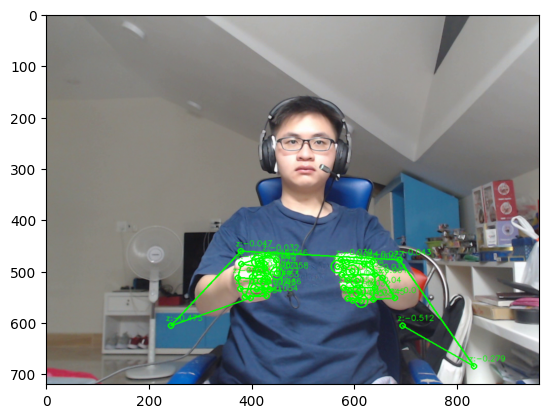

In [46]:
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))

In [272]:
# draw_landmarks(frame, results)

In [270]:
# plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# Extract Keypoint Values

In [48]:
pose = []
for index, landmark in enumerate(results.pose_landmarks.landmark):
    if index in included_landmarks:
        print(index, " - ", landmark, '\n', '---')
        pose.append([landmark.x, landmark.y, landmark.z, landmark.visibility])

11  -  x: 0.7168896
y: 0.6651891
z: -0.043094676
visibility: 0.9990746
 
 ---
12  -  x: 0.39492655
y: 0.64059204
z: -0.047454648
visibility: 0.99888474
 
 ---
13  -  x: 0.8679372
y: 0.95275116
z: -0.27859643
visibility: 0.714029
 
 ---
14  -  x: 0.253861
y: 0.8430307
z: -0.47541708
visibility: 0.75010246
 
 ---
15  -  x: 0.72329986
y: 0.84238535
z: -0.51215243
visibility: 0.82257277
 
 ---
16  -  x: 0.41507605
y: 0.7673333
z: -1.0835589
visibility: 0.8743752
 
 ---


In [49]:
len(pose)

6

In [51]:
pose_flatten = np.copy(pose).flatten()

In [52]:
pose_flatten

array([ 0.71688962,  0.66518909, -0.04309468,  0.99907458,  0.39492655,
        0.64059204, -0.04745465,  0.99888474,  0.86793721,  0.95275116,
       -0.27859643,  0.71402901,  0.25386101,  0.84303069, -0.47541708,
        0.75010246,  0.72329986,  0.84238535, -0.51215243,  0.82257277,
        0.41507605,  0.76733333, -1.08355892,  0.87437522])

In [53]:
np.zeros(6 * 4)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

In [55]:
(6*4 + 21*3 + 21*3) * 30

4500

In [13]:
# We will only be taking the landmarks of Shoulders + Arms + Wrists + 2 Hands
def extract_keypoints_v2(results):
    pose = []
    lh = []
    rh = []
    # Pose Landmarks
    if results.pose_landmarks:
        for index, landmark in enumerate(results.pose_landmarks.landmark):
            if index in included_landmarks:
                pose = np.append(pose, [landmark.x, landmark.y, landmark.z, landmark.visibility])
                # This will be flattened upon appending
    else:
        pose = np.zeros(6*4)
    # Left Hand Landmarks
    if results.left_hand_landmarks:
        lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten()
    else:
        lh = np.zeros(21*3)
    # Right Hand Landmarks
    if results.right_hand_landmarks:
        rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten()
    else:
        rh = np.zeros(21*3)

    return np.concatenate([pose, lh, rh])
        

In [83]:
np.set_printoptions(suppress=True)

In [61]:
extract_keypoints_v2(results)

array([ 0.71688962,  0.66518909, -0.04309468,  0.99907458,  0.39492655,
        0.64059204, -0.04745465,  0.99888474,  0.86793721,  0.95275116,
       -0.27859643,  0.71402901,  0.25386101,  0.84303069, -0.47541708,
        0.75010246,  0.72329986,  0.84238535, -0.51215243,  0.82257277,
        0.41507605,  0.76733333, -1.08355892,  0.87437522,  0.70831358,
        0.76679593, -0.00000014,  0.68256032,  0.71336979,  0.00104126,
        0.64562964,  0.67607707, -0.00621779,  0.61082327,  0.66959381,
       -0.01395931,  0.59130645,  0.68219125, -0.02143147,  0.6616956 ,
        0.66996658, -0.02742231,  0.59885287,  0.66526049, -0.03936275,
        0.60435206,  0.68710166, -0.03925093,  0.62118268,  0.69507235,
       -0.03753251,  0.66720665,  0.70526999, -0.03438016,  0.60049641,
        0.70481569, -0.04624613,  0.61192399,  0.72015262, -0.041039  ,
        0.63091248,  0.72093767, -0.03741381,  0.66755819,  0.73935544,
       -0.04005786,  0.60416198,  0.73934424, -0.05041449,  0.61

In [62]:
np.save('0', extract_keypoints_v2(results))

In [63]:
np.load('0.npy')

array([ 0.71688962,  0.66518909, -0.04309468,  0.99907458,  0.39492655,
        0.64059204, -0.04745465,  0.99888474,  0.86793721,  0.95275116,
       -0.27859643,  0.71402901,  0.25386101,  0.84303069, -0.47541708,
        0.75010246,  0.72329986,  0.84238535, -0.51215243,  0.82257277,
        0.41507605,  0.76733333, -1.08355892,  0.87437522,  0.70831358,
        0.76679593, -0.00000014,  0.68256032,  0.71336979,  0.00104126,
        0.64562964,  0.67607707, -0.00621779,  0.61082327,  0.66959381,
       -0.01395931,  0.59130645,  0.68219125, -0.02143147,  0.6616956 ,
        0.66996658, -0.02742231,  0.59885287,  0.66526049, -0.03936275,
        0.60435206,  0.68710166, -0.03925093,  0.62118268,  0.69507235,
       -0.03753251,  0.66720665,  0.70526999, -0.03438016,  0.60049641,
        0.70481569, -0.04624613,  0.61192399,  0.72015262, -0.041039  ,
        0.63091248,  0.72093767, -0.03741381,  0.66755819,  0.73935544,
       -0.04005786,  0.60416198,  0.73934424, -0.05041449,  0.61

In [6]:
#UNUSED
# def extract_keypoints(results):
#     pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
#     face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
#     lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
#     rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
#     return np.concatenate([pose, face, lh, rh])

# Data collection

### Setting up folders

In [7]:
#DATA COLLECTION

# data_path = os.path.join('MP_Data')
old_data_path = "K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_LandmarkData - 30fModified"
data_path = "K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_LandmarkData_10f"

# Sign Language Actions used for detection
actions = np.array(["Idle", "StaticStraight", "LSteer", "RSteer", "Boost", "Brake", "BrakeHold", "Reverse"])
# actions = np.array(["Reverse"])

# Data videos for each class and frames in each video
sequence_perclass = 100
sequence_length = 10

In [8]:
# Create folders for each class

for action in actions: 
    for sequence in range(sequence_perclass):
        try: 
            os.makedirs(os.path.join(data_path, action, str(sequence)))
        except:
            pass

In [12]:
# for action in actions: 
#     for sequence in range(sequence_perclass):
#         try: 
#             os.makedirs(os.path.join(old_data_path, action, str(sequence)))
#         except:
#             pass

In [9]:
# We will only be taking the landmarks of Shoulders + Arms + Wrists + 2 Hands
# AND this time, the coords are shifted with Left Shoulder (11) being the base (0, 0, z)
# Yes, all z coords (and vis) are still intact. Since z coords aren't really affected by x and y.
# If you're wondering why I replaced every single undetected landmarks with 0, it's because I wanted to pad my data, and if your landmark is actually
# visibile/detected on the camera, then it'd ALWAYS be different from 0.0f .
# RUN THIS IF YOU HAVEN'T
def extract_keypoints_v3(results):
    # Left Shoulder coord
    try:
        LeftSh_x = results.pose_landmarks.landmark[11].x
        LeftSh_y = results.pose_landmarks.landmark[11].y
    except:
        LeftSh_x = 0
        LeftSh_y = 0
    
    pose = []
    lh = []
    rh = []
    # Pose Landmarks (They're flipped, stated in IMPORTANT!!! READ ME)
    if results.pose_landmarks:
        for index, landmark in enumerate(results.pose_landmarks.landmark):
            if index in included_landmarks:
                pose = np.append(pose, [landmark.x - LeftSh_x, landmark.y - LeftSh_y, landmark.z, landmark.visibility])
                # This will be flattened upon appending
    else:
        pose = np.zeros(6*4)
    # Left Hand Landmarks (Technically it's the Right Hand since it's stated in IMPORTANT!!! READ ME)
    if results.left_hand_landmarks:
        lh = np.array([[res.x - LeftSh_x, res.y - LeftSh_y, res.z] for res in results.left_hand_landmarks.landmark]).flatten()
    else:
        lh = np.zeros(21*3)
    # Right Hand Landmarks (Technically it's the Left Hand since it's stated in IMPORTANT!!! READ ME)
    if results.right_hand_landmarks:
        rh = np.array([[res.x - LeftSh_x, res.y - LeftSh_y, res.z] for res in results.right_hand_landmarks.landmark]).flatten()
    else:
        rh = np.zeros(21*3)

    return np.concatenate([pose, lh, rh])


In [14]:
# We will only be taking the landmarks of Shoulders + Arms + Wrists + 2 Hands
def extract_keypoints_v2(results):
    pose = []
    lh = []
    rh = []
    # Pose Landmarks
    if results.pose_landmarks:
        for index, landmark in enumerate(results.pose_landmarks.landmark):
            if index in included_landmarks:
                pose = np.append(pose, [landmark.x, landmark.y, landmark.z, landmark.visibility])
                # This will be flattened upon appending
    else:
        pose = np.zeros(6*4)
    # Left Hand Landmarks
    if results.left_hand_landmarks:
        lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten()
    else:
        lh = np.zeros(21*3)
    # Right Hand Landmarks
    if results.right_hand_landmarks:
        rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten()
    else:
        rh = np.zeros(21*3)

    return np.concatenate([pose, lh, rh])
        

In [15]:
# Run again if needed
cap_device = 0
cap_width = 960
cap_height = 720

smooth_landmarks = False
enable_segmentation = False
smooth_segmentation = False
model_complexity = 1
min_detection_confidence = 0.5
min_tracking_confidence = 0.5

use_brect = True

# Camera Preps
cap = cv.VideoCapture(cap_device)
cap.set(cv.CAP_PROP_FRAME_WIDTH, cap_width)
cap.set(cv.CAP_PROP_FRAME_HEIGHT, cap_height)

True

In [16]:
# Run again if needed
# Mediapipe
mp_holistic = mp.solutions.holistic
holistic = mp_holistic.Holistic(
    model_complexity=model_complexity,
    smooth_landmarks=smooth_landmarks,
    enable_segmentation=enable_segmentation,
    smooth_segmentation=smooth_segmentation,
    min_detection_confidence=min_detection_confidence,
    min_tracking_confidence=min_tracking_confidence,
)

In [ ]:
# FPS Calc Module
cvFpsCalc = CvFpsCalc(buffer_len=10)

### Data collection

In [27]:
# Data Collection (1st snippet)

cap_device = 0
cap_width = 960
cap_height = 720

smooth_landmarks = False
enable_segmentation = False
smooth_segmentation = False
model_complexity = 1
min_detection_confidence = 0.5
min_tracking_confidence = 0.5

use_brect = True

# Camera Preps
cap = cv.VideoCapture(cap_device)
cap.set(cv.CAP_PROP_FRAME_WIDTH, cap_width)
cap.set(cv.CAP_PROP_FRAME_HEIGHT, cap_height)

# Mediapipe
mp_holistic = mp.solutions.holistic
holistic = mp_holistic.Holistic(
    model_complexity=model_complexity,
    smooth_landmarks=smooth_landmarks,
    enable_segmentation=enable_segmentation,
    smooth_segmentation=smooth_segmentation,
    min_detection_confidence=min_detection_confidence,
    min_tracking_confidence=min_tracking_confidence,
)

start = 0

for action in actions:
    for sequence in range(80, 100):
        for frame_num in range(sequence_length + 1):
            # display_fps = cvFpsCalc.get()
            
            # Camera Capture #####################################################
            ret, image = cap.read()
            if not ret:
                break
            image = cv.flip(image, 1)  # ミラー表示
            debug_image = copy.deepcopy(image)
            
            # Holistics Processing #############################################################
            image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
            
            image.flags.writeable = False
            results = holistic.process(image)
            image.flags.writeable = True
            
            pose_landmarks = results.pose_landmarks
            if pose_landmarks is not None:
                # 外接矩形の計算
                brect = calc_bounding_rect(debug_image, pose_landmarks)
                # 描画
                debug_image = draw_pose_landmarks_v2(
                    debug_image,
                    pose_landmarks
                )
                debug_image = draw_bounding_rect(use_brect, debug_image, brect)
            
            # Hands ###############################################################
            left_hand_landmarks = results.left_hand_landmarks
            right_hand_landmarks = results.right_hand_landmarks
            # 左手
            if left_hand_landmarks is not None:
                brect = calc_bounding_rect(debug_image, left_hand_landmarks)
                
                debug_image = draw_hand_v2(debug_image, left_hand_landmarks)
                debug_image = draw_bounding_rect(use_brect, debug_image, brect)
            # 右手
            if right_hand_landmarks is not None:
                
                brect = calc_bounding_rect(debug_image, right_hand_landmarks)
                
                debug_image = draw_hand_v2(debug_image, results.right_hand_landmarks)
                debug_image = draw_bounding_rect(use_brect, debug_image, brect)
            
            # FPS表示
            # fps_color = (0, 255, 0)
            # cv.putText(debug_image, "FPS:" + str(display_fps), (10, 30),
            #            cv.FONT_HERSHEY_SIMPLEX, 1.0, fps_color, 2, cv.LINE_AA)
            
            # Data Collection Logic ######################################################
            if frame_num == 0: 
                cv.putText(debug_image, 'STARTING COLLECTION', (120,180), 
                           cv.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 4, cv.LINE_AA)
                cv.putText(debug_image, 'Class - {}, Sequence Number {}'.format(action, sequence), (15,12), 
                           cv.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv.LINE_AA)
                cv.imshow('Data Collection Module', debug_image)
                cv.waitKey(2000)
            else: 
                cv.putText(debug_image, 'Class - {}, Sequence Number {}'.format(action, sequence), (15,12), 
                           cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv.LINE_AA)
                cv.imshow('Data Collection Module', debug_image)
            
                # Export Holistics Keypoints Data for each frame
                keypoints = extract_keypoints_v2(results)
                old_npy_path = os.path.join(old_data_path, action, str(sequence), str(frame_num - 1))
                np.save(old_npy_path, keypoints)
    
                keypoints_shifted = extract_keypoints_v3(results)
                npy_path = os.path.join(data_path, action, str(sequence), str(frame_num - 1))
                np.save(npy_path, keypoints_shifted)
            
            # キー処理(ESC：終了) #################################################
            key = cv.waitKey(10)
            if key == 27:  # ESC
                break
            
            # 画面反映 #############################################################
            # cv.imshow('Data Collection Module', debug_image)

cap.release()
cv.destroyAllWindows()

In [98]:
####collections of video sequences for each gesture (2nd snippet)

start = 0

cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    for action in actions:
        for sequence in range(start, 5):
            for frame_num in range(sequence_length):
                
                ret, frame = cap.read()
                image, results = mediapipe_detection(frame, holistic)
                draw_landmarks(image, results)
                
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Class - {}, Sequence Number {}'.format(sign, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(4000)
                else: 
                    cv2.putText(image, 'Class - {}, Sequence Number {}'.format(sign, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)
                
                # Export Holistics Keypoints Data for each frame
                keypoints = extract_keypoints_v2(results)
                npy_path = os.path.join(data_path, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [15]:
    cap.release()
    cv.destroyAllWindows()

In [105]:
# Reading test (IDLE Action)
np.load(os.path.join(data_path, "Idle", "99", "29.npy"))

array([ 0.65844977,  0.61443746, -0.28758794,  0.99967563,  0.35558844,
        0.60657746, -0.40073171,  0.9999193 ,  0.7316348 ,  0.95488411,
       -0.13574722,  0.77001089,  0.27005249,  0.92011809, -0.33331186,
        0.79169321,  0.77772176,  1.2318294 , -0.28651211,  0.09750269,
        0.21927863,  1.18768072, -0.58644634,  0.24825162,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

# Coord shifting (since my thesis requires it)

I wanted to compare my method with:
https://www.sciencedirect.com/science/article/pii/S1877050922021378 (1st target) <br>
https://journals.nauka-nanrk.kz/physics-mathematics/article/view/5454/3877 (kazakh dactyl, lstm acc is 85%, same 30f method - i might use this 4-6/2023) <br>
https://cdn.techscience.cn/files/csse/2024/TSP_CSSE-48-2/TSP_CSSE_45981/TSP_CSSE_45981.pdf (2024 article, high acc but HUGE LOSS, graph is also everywhere it seems - i might use this as well 19/3/2024) <br>
https://library.acadlore.com/JISC/2023/2/3/JISC_02.03_02.pdf (7/2023 - 30f, 87%, similar method - i might use this 1st) <br>
https://www.researchgate.net/profile/Myron-Darrel-Montefalcon/publication/362747600_Filipino_Sign_Language_Recognition_Using_Long_Short-Term_Memory_and_Residual_Network_Architecture/links/651e0f48d717ef1293cc5e70/Filipino-Sign-Language-Recognition-Using-Long-Short-Term-Memory-and-Residual-Network-Architecture.pdf (2023, same methods, 94%, i might use this <br> .src: January 2023 
DOI:10.1007/978-981-19-2397-5_4 
In book: Proceedings of Seventh International Congress on Information and Communication Technology (pp.489-497)b<br>
https://www.jstage.jst.go.jp/article/jaciii/28/2/28_265/_pdf (10/2023 - 30f method but model is not described)/br>
https://repository.msa.edu.eg/xmlui/bitstream/handle/123456789/5338/27716-61497-1-PB.pdf?sequence=1 (high acc but it delays a lot, too much epoch it went from normal to overfitting. AND NO TEST ACCURACY WHATSOEVER, only train acc which is kinda pointless)/br>
https://link.springer.com/content/pdf/10.1007/s44163-024-00113-8.pdf (thai sign lang, published 29/2/2024 so it's too late, 30f and 86% acc)/br>
http://www.jatit.org/volumes/Vol102No4/20Vol102No4.pdf 
(Same method, only has training graph, too much epochs so it kinda led to overfitting, acc is around 92-96% on test set/br>
https://jestec.taylors.edu.my/Special%20Issue%20ICIST%202022_2/ICIST_2_11.pdf (2023, 30f, same method, apparently dataset is more than mine but we're only talking about the methods here.
Graph is like how I used to did it, acc seems to be at around ~97%. Real use is around 90% i might use this as wel))l</b))

https://www.mdpi.com/2079-9292/11/19/3228 (high acc, same method but didn't show grh)a</b

https://asianssr.org/index.php/ajct/article/view/1261 (80%, same method but no graphs) <br>

https://zenodo.org/records/10047174 (98% train acc, same method but no test acc)rh)
https://deliverypdf.ssrn.com/delivery.php?ID=254067068126016002122000081016082105054014038021002005108005051114115048124098025111019021120009071120085078035006080067009013039003094075111105084065110023075024091070122011040019056019110013032104113118049040032114075127016083107079001107126096069031095005090112071104080071017079089099024&EXT=pdf&INDEX=TRUE (same method, has a couple of dropos)u</bs)

https://www.researchgate.net/profile/Ahmed-Al-Ahdal-3/publication/366125097_Indian_Sign_Language_Recognition_System_for_Dynamic_Signs/links/64ca13accaef6020543dd445/Indian-Sign-Language-Recognition-System-for-Dynamic-Signs.pdf (has comparison tae)b</br</b>)

(unrelated)
https://openaccess.thecvf.com/content/ICCV2023W/ACVR/papers/Kwolek_Continuous_Hand_Gesture_Recognition_for_Human-Robot_Collaborative_Assembly_ICCVW_2023_paper.pdf (this is a mixed bag, and they only used hand coords instead of holistic + their LSTM acc is only at ~%)7</b%)

**these are notes for myself, ignore this: For extra details on the articles, read the notes.txt in the Luan van file i
n Na4.K2**H 
<br>
**if you want to see what past me have decided to compare my method with, look up "i might use this"**

In [21]:

# LeftSh = Left Shoulder - the 11th point in the pose landmark list (well it's more like my Right Shoulder since every landmarks are literally flipped)
# Look, this one is only used to fix most of the dataset that was recorded PRIOR to me
# finding out that I kinda needed to shift the coordinates so that the dataset is somewhat unified.

def shift_coord_arr_fix(result):
    LeftSh_x = result[0]
    LeftSh_y = result[1]
    temp_result = copy.deepcopy(result)

    # Pose
    # print("- Pose x -")
    # for idx, i in enumerate(result[0:24:4]):
    for idx in range(0,24,4):
        if temp_result[idx] != 0:
            temp_result[idx] = temp_result[idx] - LeftSh_x
        else:
            continue
    # print("- Pose y -")
    for idx in range(1,24,4):
        if temp_result[idx] != 0:
            temp_result[idx] = temp_result[idx] - LeftSh_y
        else:
            continue
    # print("- Hands x -")
    for idx in range(24,150,3):
        if temp_result[idx] != 0:
            temp_result[idx] = temp_result[idx] - LeftSh_x
        else:
            continue
    # print("- Hands y -")
    for idx in range(24+1,150,3):
        if temp_result[idx] != 0:
            temp_result[idx] = temp_result[idx] - LeftSh_y
        else:
            continue

    return temp_result

In [22]:
def print_test_shifted(old, result):
    LS_x = old[0]
    LS_y = old[1]
    
    print("- Pose x -")
    for i in range(0,24,4):
        print(old[i], " - ", result[i], " - Checking if match: ", result[i] + LS_x)  # Check if results matches old by adding LS_x and LS_y
    print("- Pose y -")
    for j in range(1,24,4):
        print(old[j], " - ", result[j], " - Checking if match: ", result[j] + LS_y)
    print("- Hands x -")
    for k in range(24,150,3):
        if old[k] != 0:
            print(old[k], " - ", result[k], " - Checking if match: ", result[k] + LS_x)
        else:
            print(old[k], " - ", result[k])
    print("- Hands y -")
    for l in range(24+1,150,3):
        if old[l] != 0:
            print(old[l], " - ", result[l], " - Checking if match: ", result[l] + LS_y)
        else:
            print(old[l], " - ", result[l])

### Random test at K:\Pycharm\NLN\_holistics\__DATASET_TEMP\_LandmarkData - 30fModified\Idle\1\4.npy

In [16]:
temp_coord = copy.deepcopy(np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_LandmarkData - 30fModified",
                     "Idle",
                     "1",
                     "4" + ".npy")))

In [17]:
temp_coord_mod = shift_coord_arr_fix(temp_coord)

In [22]:
print_test_shifted(temp_coord, temp_coord_mod)

- Pose x -
0.626257598400116  -  0.0  - Checking if match:  0.626257598400116
0.3394787609577179  -  -0.28677883744239807  - Checking if match:  0.3394787609577179
0.7001647353172302  -  0.07390713691711426  - Checking if match:  0.7001647353172302
0.2604939043521881  -  -0.36576369404792786  - Checking if match:  0.2604939043521881
0.7548927068710327  -  0.12863510847091675  - Checking if match:  0.7548927068710327
0.2182779312133789  -  -0.40797966718673706  - Checking if match:  0.2182779312133789
- Pose y -
0.6004137992858887  -  0.0  - Checking if match:  0.6004137992858887
0.6018218994140625  -  0.0014081001281738281  - Checking if match:  0.6018218994140625
0.9107731580734253  -  0.3103593587875366  - Checking if match:  0.9107731580734253
0.8995139002799988  -  0.2991001009941101  - Checking if match:  0.8995139002799988
1.1617158651351929  -  0.5613020658493042  - Checking if match:  1.1617158651351929
1.1641180515289307  -  0.563704252243042  - Checking if match:  1.164118051

### This will be the loop

In [13]:
old_data_path = "K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_LandmarkData - 30fModified"
data_path = "K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_LandmarkData_10f"

# Sign Language Actions used for detection
actions_fix = np.array(["Idle", "StaticStraight", "LSteer", "RSteer", "Boost", "Brake", "BrakeHold", "Reverse"])
# actions = np.array(["Reverse"])

# Data videos for each class and frames in each video
sequence_perclass_ = 100
seq_len_ = 10

In [20]:
# Print test
print(os.path.join(data_path, actions_fix[0], "20", "5" + ".npy"))

K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_LandmarkData - 30fModified\Idle\20\5.npy


##### Loop to iterate through files to shift coords
It literally loops through each actions - each seq - each frames of the seq and modify the coords

In [14]:
for action in actions_fix:
    for sequence in range(sequence_perclass_):
        for frame_num in range(seq_len_):            
            # Getting a copy of the processed array
            old_npy_path = os.path.join(old_data_path, action, str(sequence), str(frame_num) + ".npy")
            npy_path = os.path.join(data_path, action, str(sequence), str(frame_num) + ".npy") # Get path
            og_arr = np.load(old_npy_path) # Get npy file from path
            
            np.save(npy_path, og_arr) # Rewrite npy coord file
            
            # np.save(npy_path, keypoints)

Now we check

In [15]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_LandmarkData - 30fModified",
                     "StaticStraight",
                     "20",
                     "4" + ".npy"))[0:24]

array([ 0.        ,  0.        , -0.0915085 ,  0.99999428, -0.27478421,
        0.00181961, -0.12472059,  0.99998295,  0.10549438,  0.28545672,
       -0.20308556,  0.99202794, -0.38464311,  0.25364226, -0.34217805,
        0.99240124,  0.03306043,  0.24826753, -0.65558684,  0.99653769,
       -0.30238724,  0.21315581, -0.8660571 ,  0.99256212])

In [16]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_LandmarkData_10f",
                     "StaticStraight",
                     "20",
                     "4" + ".npy"))[0:24]

array([ 0.        ,  0.        , -0.0915085 ,  0.99999428, -0.27478421,
        0.00181961, -0.12472059,  0.99998295,  0.10549438,  0.28545672,
       -0.20308556,  0.99202794, -0.38464311,  0.25364226, -0.34217805,
        0.99240124,  0.03306043,  0.24826753, -0.65558684,  0.99653769,
       -0.30238724,  0.21315581, -0.8660571 ,  0.99256212])

In [377]:
print_test_shifted(np.load("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_LandmarkData/Reverse/99/29.npy"),
                  np.load("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_LandmarkData - 30fModified/Reverse/99/29.npy"))

- Pose x -
0.703833818435669  -  0.0  - Checking if match:  0.703833818435669
0.35620561242103577  -  -0.3476282060146332  - Checking if match:  0.35620561242103577
0.8512423038482666  -  0.14740848541259766  - Checking if match:  0.8512423038482666
0.211069256067276  -  -0.49276456236839294  - Checking if match:  0.211069256067276
0.6659799218177795  -  -0.037853896617889404  - Checking if match:  0.6659799218177795
0.3448898494243622  -  -0.35894396901130676  - Checking if match:  0.3448898494243622
- Pose y -
0.5019864439964294  -  0.0  - Checking if match:  0.5019864439964294
0.5007333755493164  -  -0.0012530684471130371  - Checking if match:  0.5007333755493164
0.8652983903884888  -  0.3633119463920593  - Checking if match:  0.8652983903884888
0.8767989873886108  -  0.3748125433921814  - Checking if match:  0.8767989873886108
0.8225061893463135  -  0.32051974534988403  - Checking if match:  0.8225061893463135
0.8036545515060425  -  0.30166810750961304  - Checking if match:  0.8036

In [86]:
print_test_shifted(np.load("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_LandmarkData/Boost/99/29.npy"),
                  np.load("K:/Pycharm/NLN/_holistics//__DATASET_TEMP/_LandmarkData - 30fModified/Boost/99/29.npy"))

- Pose x -
0.640149712562561  -  0.0  - Checking if match:  0.640149712562561
0.3765622079372406  -  -0.26358750462532043  - Checking if match:  0.3765622079372406
0.754505455493927  -  0.11435574293136597  - Checking if match:  0.754505455493927
0.2769378423690796  -  -0.36321187019348145  - Checking if match:  0.2769378423690796
0.7093592882156372  -  0.06920957565307617  - Checking if match:  0.7093592882156372
0.312389075756073  -  -0.32776063680648804  - Checking if match:  0.312389075756073
- Pose y -
0.5455324649810791  -  0.0  - Checking if match:  0.5455324649810791
0.5479549169540405  -  0.0024224519729614258  - Checking if match:  0.5479549169540405
0.755280077457428  -  0.20974761247634888  - Checking if match:  0.755280077457428
0.788211464881897  -  0.24267899990081787  - Checking if match:  0.788211464881897
0.713674783706665  -  0.16814231872558594  - Checking if match:  0.713674783706665
0.7168201208114624  -  0.1712876558303833  - Checking if match:  0.716820120811462

For **IDLE**:
- Reason why I print out the whole frame's landmarks is because I wanted to check whether the Hand landmarks are affected.
- Since they're practically non-existent here, I replaced them with np.zeros. If everything actually goes fine then they won't be shifted because they don't exist.

In [26]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_LandmarkData",
                     "Idle",
                     "20",
                     "4" + ".npy"))[0:]

array([ 0.63022172,  0.59902877, -0.15674686,  0.99977833,  0.33475593,
        0.59763134, -0.29569992,  0.99991953,  0.70881355,  0.91570961,
       -0.04877936,  0.64001966,  0.24987875,  0.88756478, -0.26220018,
        0.59452164,  0.76876581,  1.18637908, -0.1515135 ,  0.03727971,
        0.18424317,  1.17475986, -0.45490092,  0.11801372,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [27]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_LandmarkData - 30fModified",
                     "Idle",
                     "20",
                     "4" + ".npy"))[0:]

array([ 0.        ,  0.        , -0.15674686,  0.99977833, -0.2954658 ,
       -0.00139743, -0.29569992,  0.99991953,  0.07859182,  0.31668085,
       -0.04877936,  0.64001966, -0.38034298,  0.28853601, -0.26220018,
        0.59452164,  0.13854408,  0.58735031, -0.1515135 ,  0.03727971,
       -0.44597855,  0.5757311 , -0.45490092,  0.11801372,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [28]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_LandmarkData",
                     "LSteer",
                     "20",
                     "4" + ".npy"))[0:24]

array([ 0.6501826 ,  0.5786705 , -0.09725313,  0.99998915,  0.36616135,
        0.5690363 , -0.19673795,  0.99997878,  0.78181243,  0.84699917,
       -0.31430575,  0.99617982,  0.24564162,  0.82565182, -0.46297911,
        0.9955349 ,  0.70400816,  0.77849764, -0.9111414 ,  0.99864703,
        0.34647363,  0.76925957, -1.06509101,  0.99607325])

In [29]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_LandmarkData - 30fModified",
                     "LSteer",
                     "20",
                     "4" + ".npy"))[0:24]

array([ 0.        ,  0.        , -0.09725313,  0.99998915, -0.28402126,
       -0.0096342 , -0.19673795,  0.99997878,  0.13162982,  0.26832867,
       -0.31430575,  0.99617982, -0.40454099,  0.24698132, -0.46297911,
        0.9955349 ,  0.05382556,  0.19982713, -0.9111414 ,  0.99864703,
       -0.30370897,  0.19058907, -1.06509101,  0.99607325])

In [30]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_LandmarkData",
                     "RSteer",
                     "20",
                     "4" + ".npy"))[0:24]

array([ 0.65011245,  0.56952953, -0.05712624,  0.99999583,  0.38764256,
        0.57304537, -0.09539817,  0.99998868,  0.75476748,  0.84319359,
       -0.12145759,  0.9892652 ,  0.28264803,  0.83261013, -0.25173005,
        0.99195075,  0.68009442,  0.77506793, -0.45914996,  0.99762863,
        0.36999619,  0.77267379, -0.64142293,  0.99430817])

In [31]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_LandmarkData - 30fModified",
                     "RSteer",
                     "20",
                     "4" + ".npy"))[0:24]

array([ 0.        ,  0.        , -0.05712624,  0.99999583, -0.26246989,
        0.00351584, -0.09539817,  0.99998868,  0.10465503,  0.27366406,
       -0.12145759,  0.9892652 , -0.36746442,  0.2630806 , -0.25173005,
        0.99195075,  0.02998197,  0.20553839, -0.45914996,  0.99762863,
       -0.28011626,  0.20314425, -0.64142293,  0.99430817])

In [32]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_LandmarkData",
                     "Boost",
                     "20",
                     "4" + ".npy"))[0:24]

array([ 0.66954714,  0.6134038 , -0.08125921,  0.99998951,  0.37670428,
        0.61595649, -0.12614077,  0.99996698,  0.79046154,  0.90662128,
       -0.26302502,  0.99035043,  0.26804212,  0.89297485, -0.35130322,
        0.98428774,  0.68979591,  0.79409462, -0.7097643 ,  0.99654913,
        0.37098324,  0.837457  , -0.8419438 ,  0.98666453])

In [33]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_LandmarkData - 30fModified",
                     "Boost",
                     "20",
                     "4" + ".npy"))[0:24]

array([ 0.        ,  0.        , -0.08125921,  0.99998951, -0.29284286,
        0.00255269, -0.12614077,  0.99996698,  0.1209144 ,  0.29321748,
       -0.26302502,  0.99035043, -0.40150502,  0.27957106, -0.35130322,
        0.98428774,  0.02024877,  0.18069082, -0.7097643 ,  0.99654913,
       -0.2985639 ,  0.2240532 , -0.8419438 ,  0.98666453])

In [34]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_LandmarkData",
                     "Brake",
                     "20",
                     "4" + ".npy"))[0:24]

array([ 0.64712131,  0.57310867, -0.0839982 ,  0.99999487,  0.35277873,
        0.56360102, -0.13058749,  0.99998653,  0.74412572,  0.85677916,
       -0.2702381 ,  0.98947424,  0.26235849,  0.86599708, -0.41171196,
        0.98569703,  0.69484657,  0.8033877 , -0.80813855,  0.99746251,
        0.33789989,  0.79509717, -1.03453314,  0.99627703])

In [35]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_LandmarkData - 30fModified",
                     "Brake",
                     "20",
                     "4" + ".npy"))[0:24]

array([ 0.        ,  0.        , -0.0839982 ,  0.99999487, -0.29434258,
       -0.00950766, -0.13058749,  0.99998653,  0.09700441,  0.28367049,
       -0.2702381 ,  0.98947424, -0.38476282,  0.2928884 , -0.41171196,
        0.98569703,  0.04772526,  0.23027903, -0.80813855,  0.99746251,
       -0.30922142,  0.2219885 , -1.03453314,  0.99627703])

In [84]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_LandmarkData",
                     "BrakeHold",
                     "20",
                     "29" + ".npy"))[0:24]

array([ 0.62511563,  0.56044626, -0.18266323,  0.99995732,  0.32057005,
        0.55455983, -0.17264104,  0.99992466,  0.74055135,  0.89031827,
       -0.30258405,  0.98453104,  0.21137309,  0.89238316, -0.37872189,
        0.98532367,  0.57972795,  0.79926747, -0.68947107,  0.99113923,
        0.38209537,  0.790582  , -0.85076737,  0.97718257])

In [85]:
np.load(os.path.join("K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_LandmarkData - 30fModified",
                     "BrakeHold",
                     "20",
                     "29" + ".npy"))[0:24]

array([ 0.        ,  0.        , -0.18266323,  0.99995732, -0.30454558,
       -0.00588644, -0.17264104,  0.99992466,  0.11543572,  0.32987201,
       -0.30258405,  0.98453104, -0.41374254,  0.3319369 , -0.37872189,
        0.98532367, -0.04538769,  0.23882121, -0.68947107,  0.99113923,
       -0.24302027,  0.23013574, -0.85076737,  0.97718257])

# Preprocess Data + Creating Labels and Features

### Import

In [17]:
# Imports
from sklearn.model_selection import train_test_split
# from tensorflow.keras.utils import to_categorical

In [18]:
# This will be the same as the Data Collection module
# Only thing here is that it WILL be more scuffed
actions = np.array(["Idle", "StaticStraight", "LSteer", "RSteer", "Boost", "Brake", "BrakeHold", "Reverse"])
# actions_fix = np.array(["BrakeHold"])
old_data_path = "K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_LandmarkData - 30Modified"
data_path = "K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_LandmarkData_10f"
# Technically this is a dupe of _LandmarkData

sequence_perclass = 100
sequence_length = 10

In [19]:
# Label dictionary
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'Idle': 0,
 'StaticStraight': 1,
 'LSteer': 2,
 'RSteer': 3,
 'Boost': 4,
 'Brake': 5,
 'BrakeHold': 6,
 'Reverse': 7}

In [20]:
np.set_printoptions(suppress=True)

## Dataset

Checking out the processed data shape(s)

In [21]:
sequences, labels = [], []
for action in actions:
    # Every action has 100 sequences, each sequence are at 30fps
    for sequence in range(sequence_perclass):
        window = []
        # Window will be a list containing 30 frames' worth of landmarks, with each frame in its own array
        # Simply put, [[24+126], [24+126],... [24+126]]
        # We load from them npy files and then we append it to Window list
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(data_path, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [22]:
np.array(sequences).shape

(800, 10, 150)

In [23]:
labels

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,


In [24]:
labels[100]

1

In [25]:
np.array(labels).shape

(800,)

### Converting data into np arrays

In [26]:
X = np.array(sequences)
X.shape

# y = to_categorical(labels).astype(int)

(800, 10, 150)

In [27]:
y = np.array(labels)
y.shape

(800,)

### Train test split

(OLD)

X_train = 70% <br>
X_val = 15% <br>
X_test = 15% <br>
I'm doing this since my data size is kinda small (I mean, 7 gestures, 100 sequences each, each sequence has 30f, each frame has 6x4+42x3 data points...? Doesn't seem like a lot tbh.)

In [50]:
# #Train/Test/Val Split
# RANDOM_SEED = 42
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

# # Test and Val split
# X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

X_test = 15% <br>
X_val = ~13%<br>
X_train = ~72%<br>

Changed the way I split my dataset and acc+graph improved drastically. <br>
Usually I'd go for 80-20 but since I don't have that much data to work with, I opted to give test and val datasets a bit more data. <br>
Ref: https://stackoverflow.com/questions/13610074/is-there-a-rule-of-thumb-for-how-to-divide-a-dataset-into-training-and-validatio

In [28]:
RANDOM_SEED = 42

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=RANDOM_SEED)

# Train/Val Split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=RANDOM_SEED)

# Test and Val split
# X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

In [29]:
X_train.shape

(578, 10, 150)

In [30]:
X_train[50]

array([[ 0.        ,  0.        , -0.05418984, ..., -0.22626826,
         0.22051752, -0.02429699],
       [ 0.        ,  0.        , -0.06652998, ..., -0.22288206,
         0.22041756, -0.02175725],
       [ 0.        ,  0.        , -0.06407862, ..., -0.22605088,
         0.22195673, -0.02394456],
       ...,
       [ 0.        ,  0.        , -0.05940483, ..., -0.22653586,
         0.22400463, -0.02543188],
       [ 0.        ,  0.        , -0.06706747, ..., -0.22565457,
         0.22347218, -0.02519765],
       [ 0.        ,  0.        , -0.06248549, ..., -0.22697228,
         0.22493064, -0.02454297]])

In [31]:
X_train[50].shape

(10, 150)

In [32]:
X_train[0][0]

array([ 0.        ,  0.        , -0.13116024,  0.99980277, -0.29373074,
        0.00232428, -0.26815158,  0.99992871,  0.0777635 ,  0.31918848,
       -0.01747089,  0.67745554, -0.37558663,  0.29771441, -0.22676982,
        0.60045421,  0.14452404,  0.60358936, -0.11610047,  0.04444432,
       -0.44311646,  0.59778911, -0.41365898,  0.14566441,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [33]:
X_val.shape

(102, 10, 150)

In [34]:
X_test.shape

(120, 10, 150)

In [35]:
actions.shape

(8,)

In [36]:
actions.shape[0]

8

In [37]:
unique, counts = np.unique(y, return_counts=True)

print(np.asarray((unique, counts)).T)

[[  0 100]
 [  1 100]
 [  2 100]
 [  3 100]
 [  4 100]
 [  5 100]
 [  6 100]
 [  7 100]]


In [38]:
unique, counts = np.unique(y_train, return_counts=True)

print(np.asarray((unique, counts)).T)

[[ 0 72]
 [ 1 69]
 [ 2 75]
 [ 3 73]
 [ 4 75]
 [ 5 74]
 [ 6 71]
 [ 7 69]]


In [39]:
unique, counts = np.unique(y_val, return_counts=True)

print(np.asarray((unique, counts)).T)

[[ 0  8]
 [ 1 20]
 [ 2 11]
 [ 3  9]
 [ 4 15]
 [ 5 11]
 [ 6 14]
 [ 7 14]]


In [40]:
unique, counts = np.unique(y_test, return_counts=True)

print(np.asarray((unique, counts)).T)

[[ 0 20]
 [ 1 11]
 [ 2 14]
 [ 3 18]
 [ 4 10]
 [ 5 15]
 [ 6 15]
 [ 7 17]]


### !!!Saving X and y stuffs in pkl files for later use.
Because having to wait for my written loop to actually read and store 4200 sequences with 5-10 frames each sequence really got me sleepy. <br>

So the way I'll be storing these files is that: <br>
"train_30f.pkl" with [X_train, y_train]. <br>
To access them, I only need to use X_train, y_train = pkl.load(filename). <br>

In [42]:
import pickle as pkl

# Saving X_train, y_train
with open("Dataset/_10F_LandmarkData_Backup/train_10f_8gest.pkl", "wb") as f:
    pkl.dump([X_train, y_train], f)

In [43]:
# Saving X_val, y_val
with open("Dataset/_10F_LandmarkData_Backup/val_10f_8gest.pkl", "wb") as f1:
    pkl.dump([X_val, y_val], f1)

In [44]:
# Saving X_test, y_test
with open("Dataset/_10F_LandmarkData_Backup/test_10f_8gest.pkl", "wb") as f2:
    pkl.dump([X_test, y_test], f2)

In [45]:
# !!!Saving X and y
with open("Dataset/_10F_LandmarkData_Backup/Xy_10f_8gest.pkl", "wb") as f3:
    pkl.dump([X, y], f3)

### !!!Loading X and y stuffs in pkl files. (USE THEM PKL FILES TO NOT HAVE TO WAIT LIKE 10' FOR YOUR TRAINING DATA TO LOAD)

In [100]:
# Test
with open("Dataset/_30F_LandmarkData_Backup/train_30f_improv_8gest.pkl", "rb") as f:
    X_train_2, y_train_2 = pkl.load(f)

In [101]:
X_train_2[0][0]

array([ 0.        ,  0.        , -0.22830527,  0.99997711, -0.2799499 ,
        0.00928932, -0.24079314,  0.99995434,  0.09913355,  0.30561399,
       -0.40591896,  0.9891426 , -0.35746765,  0.33853543, -0.49772131,
        0.98978406, -0.03170198,  0.20329595, -0.82732785,  0.99537247,
       -0.22668952,  0.19916105, -0.98531514,  0.99128294, -0.02146667,
        0.21909052,  0.00000004, -0.02976424,  0.15177369, -0.00597205,
       -0.05824971,  0.1042375 , -0.00552353, -0.09550482,  0.07983398,
       -0.002663  , -0.12037814,  0.05983484,  0.00187902, -0.10701591,
        0.12959903, -0.0028969 , -0.12969983,  0.0907411 ,  0.00169628,
       -0.11960632,  0.08090055,  0.00485517, -0.10913682,  0.08168006,
        0.00709267, -0.11830878,  0.1618309 ,  0.00245472, -0.13127357,
        0.11938131,  0.01051691, -0.11976629,  0.10879147,  0.0118081 ,
       -0.10757166,  0.11076242,  0.01087527, -0.11885625,  0.18736368,
        0.00841752, -0.12790775,  0.14993972,  0.01630254, -0.11

In [102]:
y_train_2[0]

5

In [103]:
X_train[0][0]

array([ 0.        ,  0.        , -0.22830527,  0.99997711, -0.2799499 ,
        0.00928932, -0.24079314,  0.99995434,  0.09913355,  0.30561399,
       -0.40591896,  0.9891426 , -0.35746765,  0.33853543, -0.49772131,
        0.98978406, -0.03170198,  0.20329595, -0.82732785,  0.99537247,
       -0.22668952,  0.19916105, -0.98531514,  0.99128294, -0.02146667,
        0.21909052,  0.00000004, -0.02976424,  0.15177369, -0.00597205,
       -0.05824971,  0.1042375 , -0.00552353, -0.09550482,  0.07983398,
       -0.002663  , -0.12037814,  0.05983484,  0.00187902, -0.10701591,
        0.12959903, -0.0028969 , -0.12969983,  0.0907411 ,  0.00169628,
       -0.11960632,  0.08090055,  0.00485517, -0.10913682,  0.08168006,
        0.00709267, -0.11830878,  0.1618309 ,  0.00245472, -0.13127357,
        0.11938131,  0.01051691, -0.11976629,  0.10879147,  0.0118081 ,
       -0.10757166,  0.11076242,  0.01087527, -0.11885625,  0.18736368,
        0.00841752, -0.12790775,  0.14993972,  0.01630254, -0.11

In [104]:
y_train[0]

5

OK, this will be where I load most of them, the cells prior are mostly for testing.

In [17]:
import pickle as pkl

# Loading X_train, y_train
with open("Dataset/_10F_LandmarkData_Backup/train_10f_8gest.pkl", "rb") as f:
    X_train, y_train = pkl.load(f)

In [18]:
# Loading X_val, y_val
with open("Dataset/_10F_LandmarkData_Backup/val_10f_8gest.pkl", "rb") as f1:
    X_val, y_val = pkl.load(f1)

In [19]:
# Loading X_test, y_test
with open("Dataset/_10F_LandmarkData_Backup/test_10f_8gest.pkl", "rb") as f2:
    X_test, y_test = pkl.load(f2)

In [20]:
# Loading X, y
with open("Dataset/_10F_LandmarkData_Backup/Xy_10f_8gest.pkl", "rb") as f3:
    X, y = pkl.load(f3)

## Old Deprecated Dataset (I'm only doing this for my thesis)

Checking out the processed data shape(s)

In [33]:
sequences_, labels_ = [], []
for action in actions:
    # Every action has 100 sequences_, each sequence are at 30fps
    for sequence in range(sequence_perclass):
        window = []
        # Window will be a list containing 30 frames' worth of landmarks, with each frame in its own array
        # Simply put, [[24+126], [24+126],... [24+126]]
        # We load from them npy files and then we append it to Window list
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(old_data_path, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences_.append(window)
        labels_.append(label_map[action])

In [34]:
np.array(sequences_).shape

(800, 30, 150)

In [35]:
labels_

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,


In [36]:
labels_[100]

1

In [38]:
np.array(labels_).shape

(800,)

### Converting data into np arrays

In [119]:
X_old = np.array(sequences_)
X_old.shape

# y = to_categorical(labels).astype(int)

(800, 30, 150)

In [120]:
y_old = np.array(labels_)
y_old.shape

(800,)

### Train test split

(OLD)

X_train = 70% <br>
X_val = 15% <br>
X_test = 15% <br>
I'm doing this since my data size is kinda small (I mean, 7 gestures, 100 sequences each, each sequence has 30f, each frame has 6x4+42x3 data points...? Doesn't seem like a lot tbh.)

In [73]:
#Train/Test/Val Split
# RANDOM_SEED = 42
# X_train, X_test, y_train, y_test = train_test_split(X_old, y_old, test_size=0.3, random_state=RANDOM_SEED)

# # Test and Val split
# X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

X_test = 15% <br>
X_val = ~13%<br>
X_train = ~72%<br>

Changed the way I split my dataset and acc+graph improved drastically. <br>
Usually I'd go for 80-20 but since I don't have that much data to work with, I opted to give test and val datasets a bit more data. <br>
Ref: https://stackoverflow.com/questions/13610074/is-there-a-rule-of-thumb-for-how-to-divide-a-dataset-into-training-and-validatio

In [88]:
RANDOM_SEED = 42

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_old, y_old, test_size=0.15, random_state=RANDOM_SEED)

# Train/Val Split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=RANDOM_SEED)

# Test and Val split
# X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

In [43]:
X_train.shape

(578, 30, 150)

In [44]:
X_train[50]

array([[ 0.66042721,  0.59518915, -0.05418984, ...,  0.43415895,
         0.81570667, -0.02429699],
       [ 0.66148621,  0.59612453, -0.06652998, ...,  0.43860415,
         0.81654209, -0.02175725],
       [ 0.66088444,  0.59575099, -0.06407862, ...,  0.43483356,
         0.81770772, -0.02394456],
       ...,
       [ 0.6661101 ,  0.59977961, -0.06711352, ...,  0.45137137,
         0.81887066, -0.02441477],
       [ 0.66666347,  0.60042787, -0.06129591, ...,  0.44922832,
         0.81913924, -0.02476677],
       [ 0.66609639,  0.59988666, -0.06458151, ...,  0.4497678 ,
         0.81890506, -0.02718299]])

In [45]:
X_train[50].shape

(30, 150)

In [46]:
X_train[0][0]

array([ 0.62726063,  0.59369403, -0.13116024,  0.99980277,  0.33352989,
        0.59601831, -0.26815158,  0.99992871,  0.70502412,  0.91288251,
       -0.01747089,  0.67745554,  0.251674  ,  0.89140844, -0.22676982,
        0.60045421,  0.77178466,  1.19728339, -0.11610047,  0.04444432,
        0.18414417,  1.19148314, -0.41365898,  0.14566441,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [47]:
X_val.shape

(102, 30, 150)

In [48]:
X_test.shape

(120, 30, 150)

In [49]:
actions.shape

(8,)

In [50]:
actions.shape[0]

8

### !!!Saving X and y stuffs in pkl files for later use.
Because having to wait for my written loop to actually read and store 4200 sequences with 5-10 frames each sequence really got me sleepy. <br>

So the way I'll be storing these files is that: <br>
"train_30f.pkl" with [X_train, y_train]. <br>
To access them, I only need to use X_train, y_train = pkl.load(filename). <br>

In [51]:
import pickle as pkl

# Saving X_train, y_train
with open("Dataset/_30F_LandmarkData_Backup/train_30f-deprecated.pkl", "wb") as f:
    pkl.dump([X_train, y_train], f)

In [52]:
# Saving X_val, y_val
with open("Dataset/_30F_LandmarkData_Backup/val_30f-deprecated.pkl", "wb") as f1:
    pkl.dump([X_val, y_val], f1)

In [53]:
# Saving X_test, y_test
with open("Dataset/_30F_LandmarkData_Backup/test_30f-deprecated.pkl", "wb") as f2:
    pkl.dump([X_test, y_test], f2)

In [55]:
# !!!Saving X and y
with open("Dataset/_30F_LandmarkData_Backup/Xy_30f-deprecated.pkl", "wb") as f3:
    pkl.dump([X_old, y_old], f3)

In [25]:
import pickle as pkl

# Loading X_train, y_train
with open("Dataset/_30F_LandmarkData_Backup/train_30f-deprecated.pkl", "rb") as f:
    X_train, y_train = pkl.load(f)

In [26]:
import pickle as pkl

# Loading X_test, y_test
with open("Dataset/_30F_LandmarkData_Backup/test_30f-deprecated.pkl", "rb") as f:
    X_test, y_test = pkl.load(f)

In [27]:
import pickle as pkl

# Loading X_test, y_test
with open("Dataset/_30F_LandmarkData_Backup/val_30f-deprecated.pkl", "rb") as f:
    X_val, y_val = pkl.load(f)

# MODEL TRAINING

#### Model 1
Ref: https://www.mdpi.com/2079-9292/11/19/3228

Inp (10,150) <br>
LSTM 64 <br>
LSTM 128 <br>
LSTM 64 <br>
FC 64 <br>
FC 32 <br>
FC-Output 7 <br>
<br>
LR 0.001 - Adam <br>
BS - 32 <br>
(BS - 128; https://www.ijfmr.com/papers/2023/5/6868.pdf)

In [46]:
import tensorflow as tf

In [47]:
#
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
# np_utils is apparently removed from newer versions of Tensorflow
from keras import utils
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from tensorflow.keras import optimizers
from sklearn.svm import SVC, SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [48]:
actions = np.array(["Idle", "StaticStraight", "LSteer", "RSteer", "Boost", "Brake", "BrakeHold", "Reverse"])
NUM_OF_GESTURES = actions.shape[0]

In [59]:
### Resetting cluttered memories / old compiled models
tf.keras.backend.clear_session()

In [60]:
# del model

In [61]:
del model_1

In [62]:
#define newer LSTM model

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping

# Input shape is a sequence consisting of 10 frames, with each frame having 150 landmarks
model_1 = Sequential()
model_1.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(10,150)))
model_1.add(LSTM(128, return_sequences=True, activation='relu'))
model_1.add(LSTM(64, return_sequences=False, activation='relu'))
model_1.add(Dense(64, activation='relu'))
model_1.add(Dense(32, activation='relu'))
model_1.add(Dense(NUM_OF_GESTURES, activation='softmax'))

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    # decay_steps=int(3200/32),
    decay_rate=0.001/200)
# Decay steps: int(X_train.shape/

opt_1 = tf.keras.optimizers.Adam(learning_rate = lr_schedule)
# opt_1 = tf.keras.optimizers.legacy.Adam(learning_rate = 0.001, decay = 0.001 / 200)
model_1.compile(optimizer=opt_1, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# old model
# model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 64)            55040     
                                                                 
 lstm_1 (LSTM)               (None, 10, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
Total params: 209768 (819.41 KB)
Trainable params: 20976

In [63]:
# es = EarlyStopping(min_delta = 0.05, mode='min', patience = 30, restore_best_weights=True)

# es = EarlyStopping(patience = 20, verbose=1)

# es = EarlyStopping(min_delta = 0.05, mode='min', patience = 10, verbose=1)
es = EarlyStopping(min_delta = 0.05, mode='min', patience = 20, verbose=1)
# es = EarlyStopping(min_delta = 0.05, patience = 20)

In [64]:
#train LSTM model 2

import time

start = time.time()

history = model_1.fit(X_train, 
                    y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=200,
                    # batch_size=32,
                     # )
                    callbacks=[es]) 

print('Time to train: {}s'.format(time.time() - start))

Epoch 1/200
19/19 [==============================] - 2s 22ms/step - loss: 2.0643 - accuracy: 0.3478 - val_loss: 2.0076 - val_accuracy: 0.2353
Epoch 2/200
19/19 [==============================] - 0s 9ms/step - loss: 1.6363 - accuracy: 0.3512 - val_loss: 1.3849 - val_accuracy: 0.4412
Epoch 3/200
19/19 [==============================] - 0s 8ms/step - loss: 1.0538 - accuracy: 0.5467 - val_loss: 1.0870 - val_accuracy: 0.5980
Epoch 4/200
19/19 [==============================] - 0s 8ms/step - loss: 0.7385 - accuracy: 0.7266 - val_loss: 0.9427 - val_accuracy: 0.6667
Epoch 5/200
19/19 [==============================] - 0s 8ms/step - loss: 0.6830 - accuracy: 0.7301 - val_loss: 0.6571 - val_accuracy: 0.7941
Epoch 6/200
19/19 [==============================] - 0s 8ms/step - loss: 0.4816 - accuracy: 0.8253 - val_loss: 0.5352 - val_accuracy: 0.8137
Epoch 7/200
19/19 [==============================] - 0s 8ms/step - loss: 0.4517 - accuracy: 0.8322 - val_loss: 0.6276 - val_accuracy: 0.7647
Epoch 8/200


In [383]:
#train LSTM model

import time

start = time.time()

history = model_1.fit(X_train, 
                    y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=200,
                    # batch_size=32,
                     # )
                    callbacks=[es]) 

print('Time to train: {}s'.format(time.time() - start))

Epoch 1/200
19/19 [==============================] - 6s 125ms/step - loss: 1.9238 - accuracy: 0.2803 - val_loss: 1.5601 - val_accuracy: 0.3922
Epoch 2/200
19/19 [==============================] - 2s 103ms/step - loss: 1.6524 - accuracy: 0.4204 - val_loss: 1.4217 - val_accuracy: 0.3529
Epoch 3/200
19/19 [==============================] - 2s 102ms/step - loss: 1.9944 - accuracy: 0.4100 - val_loss: 1.8198 - val_accuracy: 0.3137
Epoch 4/200
19/19 [==============================] - 2s 103ms/step - loss: 1.4164 - accuracy: 0.4187 - val_loss: 1.1339 - val_accuracy: 0.4412
Epoch 5/200
19/19 [==============================] - 2s 103ms/step - loss: 0.9680 - accuracy: 0.6315 - val_loss: 1.2513 - val_accuracy: 0.6765
Epoch 6/200
19/19 [==============================] - 2s 103ms/step - loss: 0.5885 - accuracy: 0.8391 - val_loss: 0.6544 - val_accuracy: 0.7549
Epoch 7/200
19/19 [==============================] - 2s 102ms/step - loss: 0.3299 - accuracy: 0.8858 - val_loss: 0.5912 - val_accuracy: 0.8824

In [224]:
#train LSTM model (old depre)

import time

start = time.time()

history = model_1.fit(X_train, 
                    y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=200,
                    batch_size=32,
                     # )
                    callbacks=[es]) 

print('Time to train: {}s'.format(time.time() - start))

Epoch 1/200
19/19 [==============================] - 3s 65ms/step - loss: 1.9186 - accuracy: 0.2388 - val_loss: 1.8832 - val_accuracy: 0.2745
Epoch 2/200
19/19 [==============================] - 1s 52ms/step - loss: 1.7831 - accuracy: 0.2457 - val_loss: 1.8357 - val_accuracy: 0.1667
Epoch 3/200
19/19 [==============================] - 1s 52ms/step - loss: 1.7327 - accuracy: 0.2509 - val_loss: 1.7624 - val_accuracy: 0.1667
Epoch 4/200
19/19 [==============================] - 1s 53ms/step - loss: 1.6630 - accuracy: 0.3183 - val_loss: 1.7123 - val_accuracy: 0.1569
Epoch 5/200
19/19 [==============================] - 1s 53ms/step - loss: 440.0394 - accuracy: 0.4862 - val_loss: 1.0925 - val_accuracy: 0.5490
Epoch 6/200
19/19 [==============================] - 1s 52ms/step - loss: 35.2236 - accuracy: 0.3304 - val_loss: 2.0127 - val_accuracy: 0.1667
Epoch 7/200
19/19 [==============================] - 1s 54ms/step - loss: 1.6873 - accuracy: 0.2872 - val_loss: 1.6824 - val_accuracy: 0.2745
Epo

In [288]:
# model_1.save("models/30f_improv/30f-claiomh.keras")

In [65]:
model_1.save("models/10f_test/10f-fin.keras")

In [131]:
# model_1.save("models/30f_deprecated/30f-1-lstm_model_1.keras")

In [66]:
# Saving history_1
import pickle as pkl

# Saving history
with open("models/10f_test/history_fin_1.pkl", "wb") as f:
    pkl.dump(history, f)

Best results(?) yet are saved here

In [ ]:
tf.compat.v1.reset_default_graph()

In [ ]:
# from tensorflow import keras

# keras.utils.plot_model(
#     model_1,
#     to_file="models/30f_improv/model.png",
#     show_shapes=True,
#     show_dtype=False,
#     show_layer_names=True,
#     rankdir="TB",
#     expand_nested=False,
#     dpi=200,
#     show_layer_activations=True,
#     show_trainable=True,
# )

Based on https://ajec.smartsociety.org/wp-content/uploads/2023/01/5.pdf
https://github.com/soumadeepsarkar1/Sign-Language-Recognition/blob/main/Our%20research%20paper%20published%20in%20AJEC.pdf

#### Model 7 (UPDATED)
Inp (10,150) <br>
LSTM 64 ret_seq = F tanh <br>
FC 64<br>
BatchNorm <br>
LeakyReLU <br>
FC 32 <br>
BatchNorm <br>
LeakyReLU <br>
FC-Output 7 Softmax <br>
<br>
LR 0.003 - Adam - BS 64 - 150 Epochs <br>
LR Inverse Decay : decay steps = 8, decay rate = .5, staircase = F

In [67]:
import tensorflow as tf

In [68]:
#
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
# np_utils is apparently removed from newer versions of Tensorflow
from keras import utils
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from tensorflow.keras import optimizers
from sklearn.svm import SVC, SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [69]:
NUM_OF_GESTURES = actions.shape[0]

In [136]:
### Resetting cluttered memories / old compiled models
tf.keras.backend.clear_session()

In [137]:
# del model

In [138]:
del model_7

In [139]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping

# Input shape is a sequence consisting of 10 frames, with each frame having 150 landmarks
model_7 = Sequential()
model_7.add(LSTM(64, return_sequences=False, activation='tanh', input_shape=(10,150), 
                kernel_regularizer=tf.keras.regularizers.L2(l2=0.044),
                recurrent_regularizer=tf.keras.regularizers.L2(l2=0.014)))
model_7.add(Dense(64, kernel_regularizer=tf.keras.regularizers.L2(l2=0.027)))
model_7.add(BatchNormalization())
model_7.add(LeakyReLU())
model_7.add(Dense(32, kernel_regularizer=tf.keras.regularizers.L2(l2=0.027)))
model_7.add(BatchNormalization())
model_7.add(LeakyReLU())
model_7.add(Dense(NUM_OF_GESTURES, activation='softmax'))

# learning rate decay, used it because the loss was abruptly increasing while fitting the model, which
# meant that learning rate was note small enough
# batch normalization also kinda helped, might consider using it again
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.003,
    decay_steps=8,
    decay_rate=0.5,
    staircase=False)

opt_7 = tf.optimizers.Adam(learning_rate=lr_schedule)
model_7.compile(optimizer=opt_7, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_7.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                55040     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_1 (Bat  (None, 32)                128       
 chNormalization)                                       

In [87]:
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [140]:
# es = EarlyStopping(min_delta = 0.05, mode='min', patience = 30, restore_best_weights=True)

# es = EarlyStopping(patience = 20, verbose=1)

es = EarlyStopping(min_delta = 0.05, mode='min', patience = 30, verbose=1)
# es = EarlyStopping(min_delta = 0.05, patience = 20)

In [133]:
#train LSTM model

import time

start = time.time()

history_7 = model_7.fit(X_train, 
                    y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=300,
                    batch_size=16
                    ,
                    callbacks=[es]) 

print('Time to train: {}s'.format(time.time() - start))

Epoch 1/300
37/37 [==============================] - 2s 10ms/step - loss: 8.9757 - accuracy: 0.7111 - val_loss: 7.3442 - val_accuracy: 0.2059
Epoch 2/300
37/37 [==============================] - 0s 3ms/step - loss: 5.0083 - accuracy: 0.9308 - val_loss: 5.7875 - val_accuracy: 0.3529
Epoch 3/300
37/37 [==============================] - 0s 3ms/step - loss: 3.8483 - accuracy: 0.9654 - val_loss: 5.1483 - val_accuracy: 0.1471
Epoch 4/300
37/37 [==============================] - 0s 2ms/step - loss: 3.2981 - accuracy: 0.9671 - val_loss: 4.7745 - val_accuracy: 0.1569
Epoch 5/300
37/37 [==============================] - 0s 2ms/step - loss: 3.0209 - accuracy: 0.9758 - val_loss: 4.4924 - val_accuracy: 0.2353
Epoch 6/300
37/37 [==============================] - 0s 2ms/step - loss: 2.8201 - accuracy: 0.9689 - val_loss: 4.3113 - val_accuracy: 0.2353
Epoch 7/300
37/37 [==============================] - 0s 2ms/step - loss: 2.6183 - accuracy: 0.9844 - val_loss: 4.1080 - val_accuracy: 0.3039
Epoch 8/300


In [141]:
#train LSTM model 2

import time

start = time.time()

history_7_2 = model_7.fit(X_train, 
                    y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=300,
                    batch_size=16
                    ,
                    callbacks=[es]) 

print('Time to train: {}s'.format(time.time() - start))

Epoch 1/300
37/37 [==============================] - 2s 10ms/step - loss: 8.9148 - accuracy: 0.7612 - val_loss: 7.3301 - val_accuracy: 0.6765
Epoch 2/300
37/37 [==============================] - 0s 3ms/step - loss: 5.1040 - accuracy: 0.8997 - val_loss: 5.8155 - val_accuracy: 0.6961
Epoch 3/300
37/37 [==============================] - 0s 3ms/step - loss: 3.9862 - accuracy: 0.9533 - val_loss: 5.1823 - val_accuracy: 0.4706
Epoch 4/300
37/37 [==============================] - 0s 2ms/step - loss: 3.4712 - accuracy: 0.9619 - val_loss: 4.7829 - val_accuracy: 0.5294
Epoch 5/300
37/37 [==============================] - 0s 2ms/step - loss: 3.1210 - accuracy: 0.9792 - val_loss: 4.5138 - val_accuracy: 0.5588
Epoch 6/300
37/37 [==============================] - 0s 3ms/step - loss: 2.9170 - accuracy: 0.9706 - val_loss: 4.2826 - val_accuracy: 0.7059
Epoch 7/300
37/37 [==============================] - 0s 2ms/step - loss: 2.7417 - accuracy: 0.9810 - val_loss: 4.0565 - val_accuracy: 0.6569
Epoch 8/300


In [110]:
model_7.save("models/10f_test/10f-7-fin.keras")

In [142]:
model_7.save("models/10f_test/10f-7-fin-land.keras")

In [131]:
# model_7.save("models/7-lstm_model_7.keras")

In [348]:
# Saving history_1
import pickle as pkl

# Saving history
with open("models/10f_test/history_7.pkl", "wb") as f:
    pkl.dump(history_7, f)

In [143]:
# Saving history_1
import pickle as pkl

# Saving history
with open("models/10f_test/history_7_2.pkl", "wb") as f:
    pkl.dump(history_7_2, f)

In [135]:
# Saving history_1
import pickle as pkl

# Saving history
with open("models/10f_test/history_7_fin.pkl", "wb") as f:
    pkl.dump(history_7, f)

In [ ]:
import tensorflow as tf

with open("models/10f_test/history_7_fin.pkl", "rb") as f:
    history = pkl.load(f)

# MODEL EVALUATING

Do note that these are different from the main modules, with these model's datasets are only comprised of...
100 sequences, with each sequences having 10frames out the initial 30frames of the original dataset

#### Model 1
Ref: https://www.mdpi.com/2079-9292/11/19/3228

Inp (10,150) <br>
LSTM 64 <br>
LSTM 128 <br>
LSTM 64 <br>
FC 64 <br>
FC 32 <br>
FC-Output 7 <br>
<br>
LR 0.001 - Adam <br>
BS - 32 <br>
(BS - 128; https://www.ijfmr.com/papers/2023/5/6868.pdf)

Data splitted as follows: <br>
Train / Val = 75% / 15% <br>
Train / Test = 75% of initial Train / 15% of initial Train

In [ ]:
# import tensorflow as tf

# with open("models/30f_improv/history_8gest_okacc.pkl", "rb") as f:
#     history = pkl.load(f)

In [17]:
import pickle as pkl

# Loading X_train, y_train
with open("Dataset/_10F_LandmarkData_Backup/train_10f_8gest.pkl", "rb") as f:
    X_train, y_train = pkl.load(f)

In [18]:
# Loading X_val, y_val
with open("Dataset/_10F_LandmarkData_Backup/val_10f_8gest.pkl", "rb") as f1:
    X_val, y_val = pkl.load(f1)

In [19]:
# Loading X_test, y_test
with open("Dataset/_10F_LandmarkData_Backup/test_10f_8gest.pkl", "rb") as f2:
    X_test, y_test = pkl.load(f2)

In [20]:
# Loading X, y
with open("Dataset/_10F_LandmarkData_Backup/Xy_10f_8gest.pkl", "rb") as f3:
    X, y = pkl.load(f3)

In [42]:
# model_1 = keras.models.load_model("models/30f_improv/30f-claiomh-8gest_okacc.keras")
model_1 = keras.models.load_model("models/10f_test/10f-fin.keras")
# model_1 = keras.models.load_model("models/30f_improv/30f-claiomh-8gest_bestacc.keras")

In [ ]:
import tensorflow as tf

with open("models/10f_test/history_fin_1.pkl", "rb") as f:
    history = pkl.load(f)

In [144]:
# evaluate the model
_, train_acc = model_1.evaluate(X_train, y_train, verbose=0)
_, val_acc = model_1.evaluate(X_val, y_val, verbose=0)
_, test_acc = model_1.evaluate(X_test, y_test, verbose=0)
print('Train: %.4f, Validation: %.4f, Test %.4f' % (train_acc, val_acc, test_acc))

Train: 0.9827, Validation: 0.9608, Test 0.9667


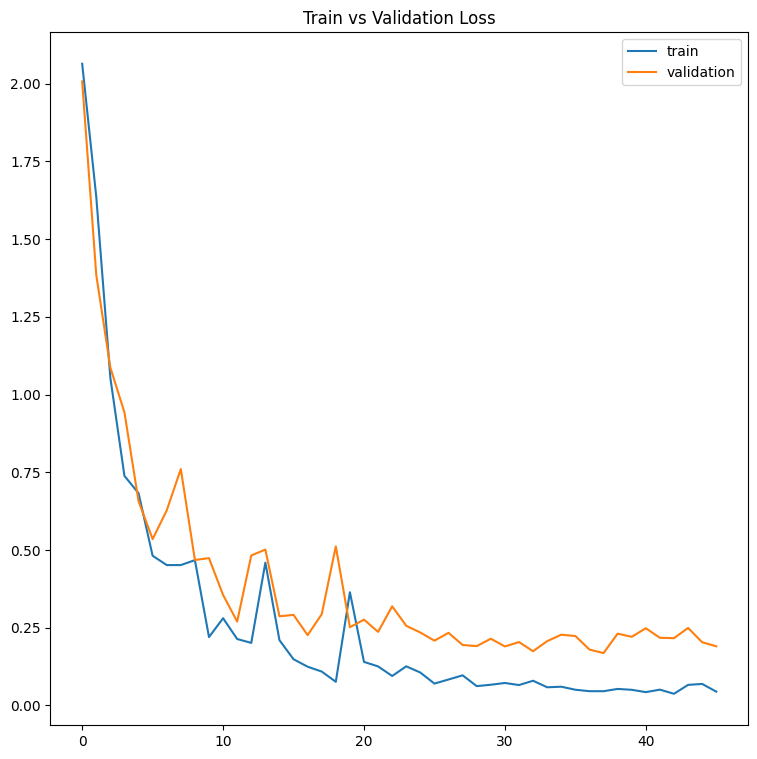

In [145]:
import matplotlib.pyplot as plt



# plot loss history
plt.figure(figsize=(9,9))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

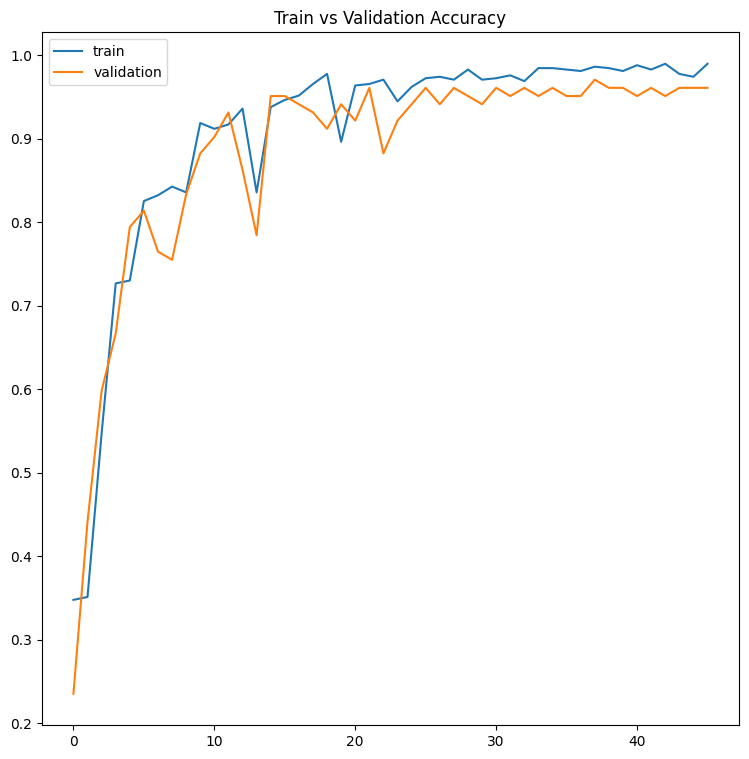

In [146]:
# plot accuracy history
plt.figure(figsize=(9,9))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.show()

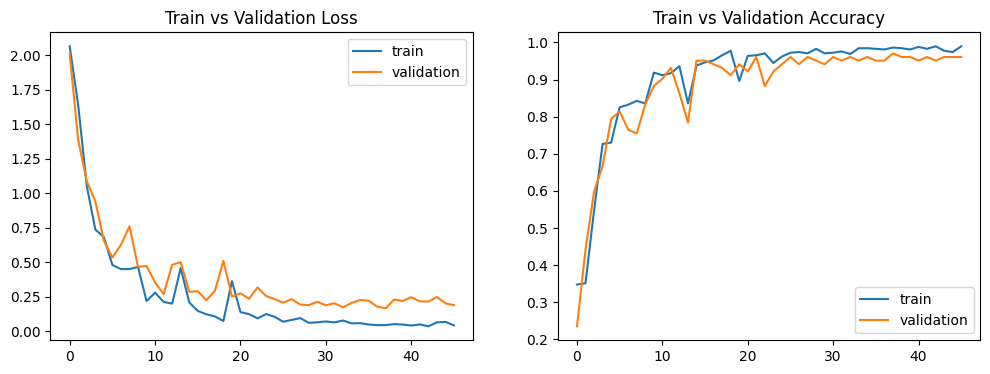

In [147]:
plt.subplots(nrows = 1, ncols = 2, figsize=(12, 4))

# plot loss history
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Train vs Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Train vs Validation Accuracy')
plt.legend()

plt.show()

In [47]:
# model.save('lstm_action_recog3.keras')

In [48]:
# model.load_weights('lstm_action_recog3.keras')

4/4 [==============================] - 0s 3ms/step


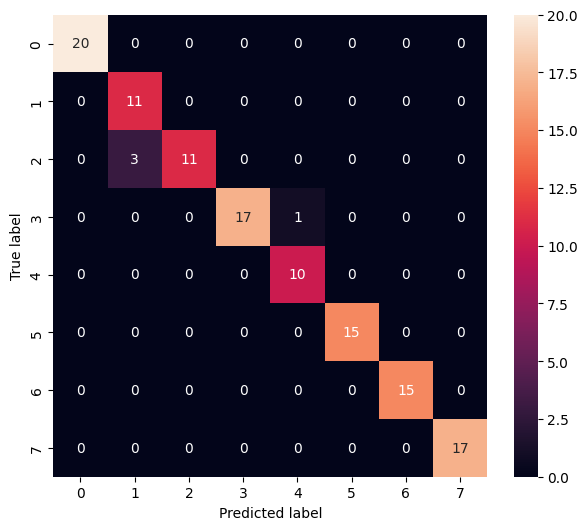

Classification Report
              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000        20
           1    0.78571   1.00000   0.88000        11
           2    1.00000   0.78571   0.88000        14
           3    1.00000   0.94444   0.97143        18
           4    0.90909   1.00000   0.95238        10
           5    1.00000   1.00000   1.00000        15
           6    1.00000   1.00000   1.00000        15
           7    1.00000   1.00000   1.00000        17

    accuracy                        0.96667       120
   macro avg    0.96185   0.96627   0.96048       120
weighted avg    0.97278   0.96667   0.96675       120



"\n{'Idle': 0,\n 'StaticStraight': 1,\n 'LSteer': 2,\n 'RSteer': 3,\n 'Boost': 4,\n 'Brake': 5,\n 'BrakeHold': 6}\n"

In [148]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_true, y_pred, digits=5))

Y_pred = model_1.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

'''
{'Idle': 0,
 'StaticStraight': 1,
 'LSteer': 2,
 'RSteer': 3,
 'Boost': 4,
 'Brake': 5,
 'BrakeHold': 6}
'''


In [25]:
import pickle as pkl

# Loading X_train, y_train
with open("Dataset/_30F_LandmarkData_Backup/train_30f-deprecated.pkl", "rb") as f:
    X_train, y_train = pkl.load(f)

In [26]:
import pickle as pkl

# Loading X_test, y_test
with open("Dataset/_30F_LandmarkData_Backup/test_30f-deprecated.pkl", "rb") as f:
    X_test, y_test = pkl.load(f)

In [27]:
import pickle as pkl

# Loading X_test, y_test
with open("Dataset/_30F_LandmarkData_Backup/val_30f-deprecated.pkl", "rb") as f:
    X_val, y_val = pkl.load(f)

In [33]:
model_1 = keras.models.load_model('models/30f_deprecated/30f-lstm_model_2-deprecated.keras')

In [29]:
import tensorflow as tf

with open("models/30f_deprecated/history_1.pkl", "rb") as f:
    history = pkl.load(f)

Time to train: 42.88704538345337s

Train: 0.9446, Validation: 0.9020, Test 0.9417


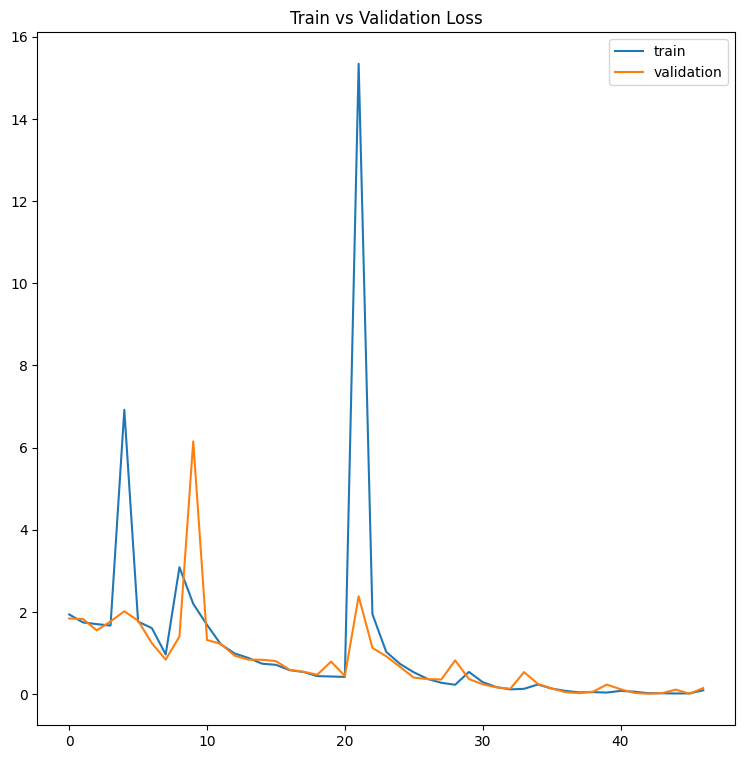

In [34]:
import matplotlib.pyplot as plt

# evaluate the model
_, train_acc = model_1.evaluate(X_train, y_train, verbose=0)
_, val_acc = model_1.evaluate(X_val, y_val, verbose=0)
_, test_acc = model_1.evaluate(X_test, y_test, verbose=0)
print('Train: %.4f, Validation: %.4f, Test %.4f' % (train_acc, val_acc, test_acc))

# plot loss history
plt.figure(figsize=(9,9))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

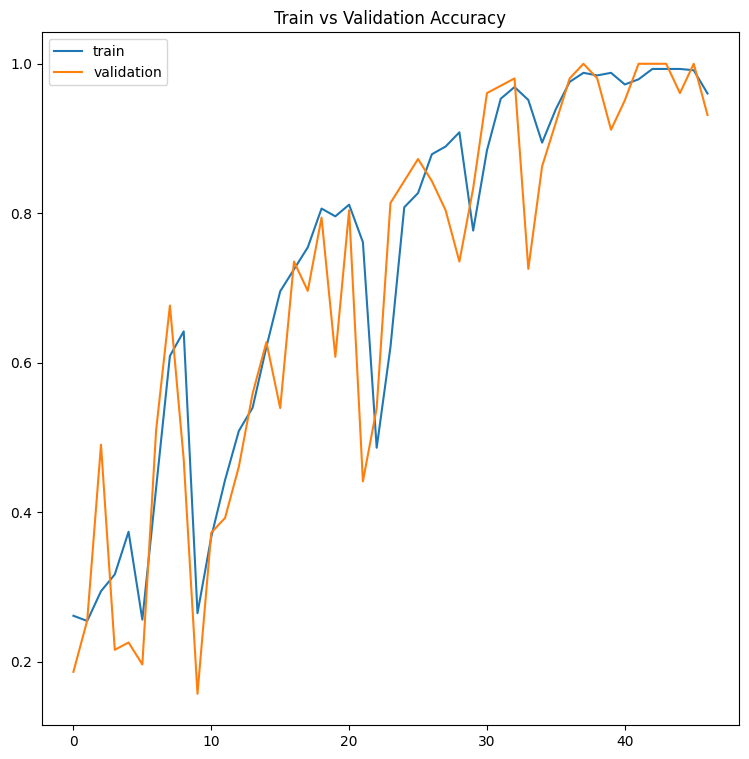

In [31]:
# plot accuracy history
plt.figure(figsize=(9,9))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.show()

In [47]:
# model.save('lstm_action_recog3.keras')

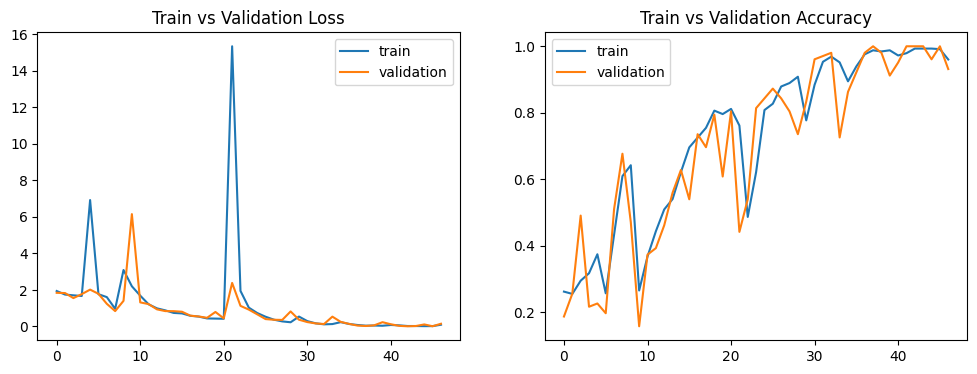

In [36]:
plt.subplots(nrows = 1, ncols = 2, figsize=(12, 4))

# plot loss history
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Train vs Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Train vs Validation Accuracy')
plt.legend()

plt.show()

In [48]:
# model.load_weights('lstm_action_recog3.keras')

4/4 [==============================] - 0s 8ms/step


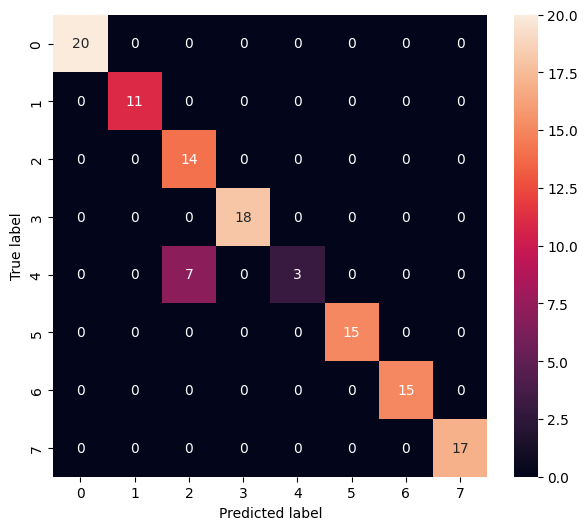

Classification Report
              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000        20
           1    1.00000   1.00000   1.00000        11
           2    0.66667   1.00000   0.80000        14
           3    1.00000   1.00000   1.00000        18
           4    1.00000   0.30000   0.46154        10
           5    1.00000   1.00000   1.00000        15
           6    1.00000   1.00000   1.00000        15
           7    1.00000   1.00000   1.00000        17

    accuracy                        0.94167       120
   macro avg    0.95833   0.91250   0.90769       120
weighted avg    0.96111   0.94167   0.93179       120



"\n{'Idle': 0,\n 'StaticStraight': 1,\n 'LSteer': 2,\n 'RSteer': 3,\n 'Boost': 4,\n 'Brake': 5,\n 'BrakeHold': 6}\n"

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_true, y_pred, digits=5))

Y_pred = model_1.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

'''
{'Idle': 0,
 'StaticStraight': 1,
 'LSteer': 2,
 'RSteer': 3,
 'Boost': 4,
 'Brake': 5,
 'BrakeHold': 6}
'''


Based on https://ajec.smartsociety.org/wp-content/uploads/2023/01/5.pdf
https://github.com/soumadeepsarkar1/Sign-Language-Recognition/blob/main/Our%20research%20paper%20published%20in%20AJEC.pdf

#### Model 7 (UPDATED)
Inp (10,150) <br>
LSTM 64 ret_seq = F tanh <br>
FC 64<br>
BatchNorm <br>
LeakyReLU <br>
FC 32 <br>
BatchNorm <br>
LeakyReLU <br>
FC-Output 7 Softmax <br>
<br>
LR 0.002 - Adam - BS 64 - 150 Epochs <br>
LR Inverse Decay : decay steps = 8, decay rate = .5, staircase = F

Data splitted as follows: <br>
Train / Val = 75% / 15% <br>
Train / Test = 75% of initial Train / 15% of initial Train

In [ ]:
# models/10f_test/10f-7-fin-land.keras
model_7 = keras.models.load_model("models/10f_test/10f-7-fin-land.keras")

In [ ]:
import tensorflow as tf

with open("models/10f_test/history_7_2.pkl", "rb") as f:
    history_7_2 = pkl.load(f)

In [153]:
# models/10f_test/10f-7-fin-land.keras
model_7 = keras.models.load_model("models/10f_test/10f-7-fin.keras")

In [154]:
import tensorflow as tf

with open("models/10f_test/history_7_fin.pkl", "rb") as f:
    history_7 = pkl.load(f)

In [155]:
# evaluate the model
_, train_acc = model_7.evaluate(X_train, y_train, verbose=0)
_, val_acc = model_7.evaluate(X_val, y_val, verbose=0)
_, test_acc = model_7.evaluate(X_test, y_test, verbose=0)
print('Train: %.4f, Validation: %.4f, Test %.4f' % (train_acc, val_acc, test_acc))

Train: 0.9965, Validation: 0.9902, Test 0.9917


Train: 0.997, Validation: 0.990


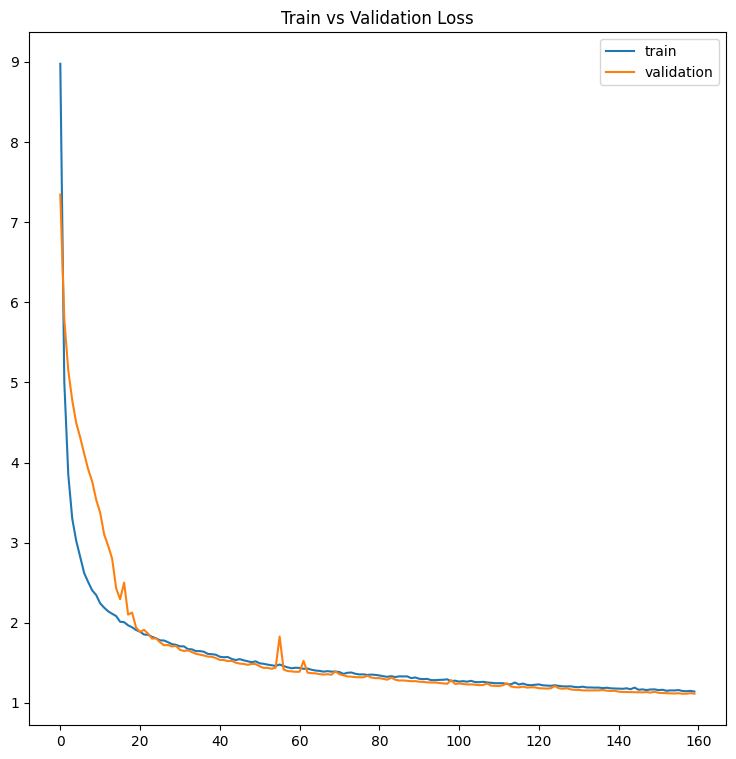

In [156]:
import matplotlib.pyplot as plt

# evaluate the model
_, train_acc = model_7.evaluate(X_train, y_train, verbose=0)
_, val_acc = model_7.evaluate(X_val, y_val, verbose=0)
print('Train: %.3f, Validation: %.3f' % (train_acc, val_acc))

# plot loss history
plt.figure(figsize=(9,9))
plt.plot(history_7.history['loss'], label='train')
plt.plot(history_7.history['val_loss'], label='validation')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

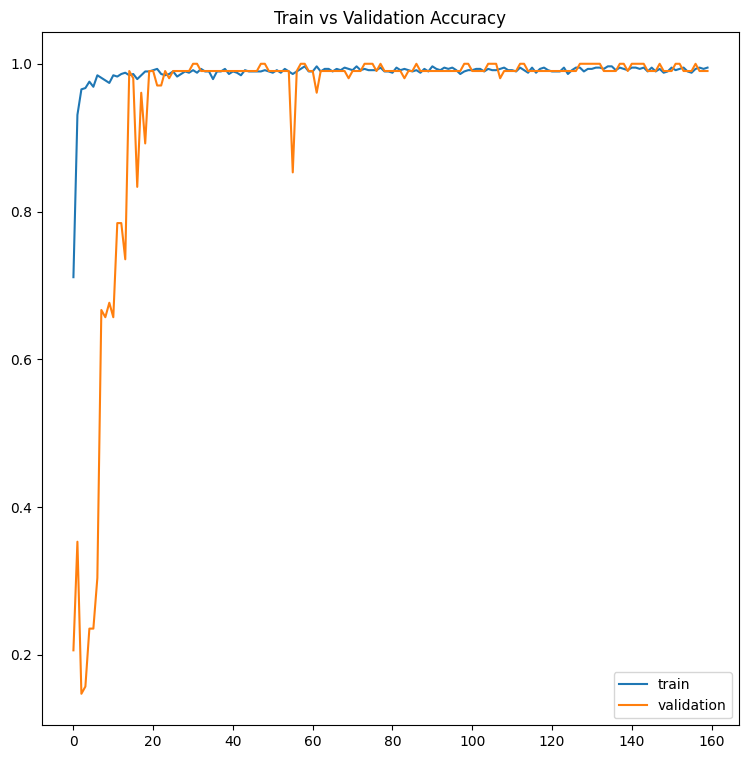

In [157]:
# plot accuracy history
plt.figure(figsize=(9,9))
plt.plot(history_7.history['accuracy'], label='train')
plt.plot(history_7.history['val_accuracy'], label='validation')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.show()

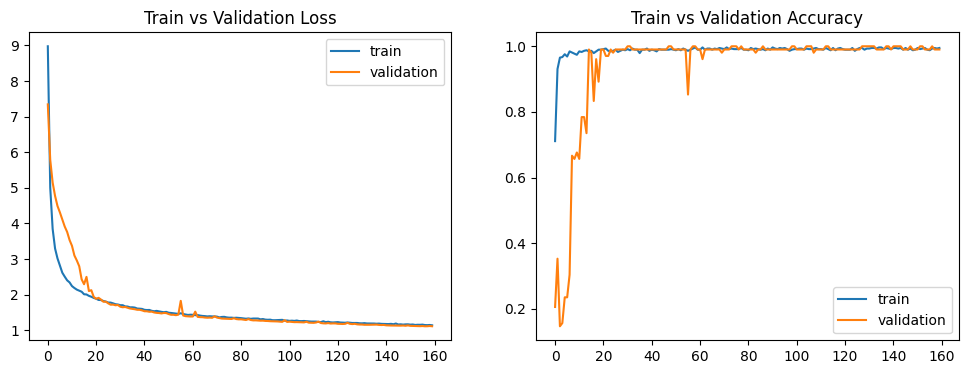

In [159]:
plt.subplots(nrows = 1, ncols = 2, figsize=(12, 4))

# plot loss history
plt.subplot(1, 2, 1)
plt.plot(history_7.history['loss'], label='train')
plt.plot(history_7.history['val_loss'], label='validation')
plt.title('Train vs Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_7.history['accuracy'], label='train')
plt.plot(history_7.history['val_accuracy'], label='validation')
plt.title('Train vs Validation Accuracy')
plt.legend()

plt.show()

In [47]:
# model.save('lstm_action_recog3.keras')

In [48]:
# model.load_weights('lstm_action_recog3.keras')

4/4 [==============================] - 0s 2ms/step


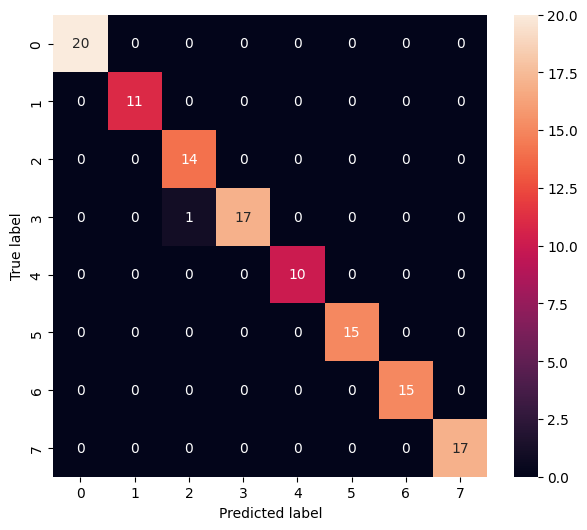

Classification Report
              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000        20
           1    1.00000   1.00000   1.00000        11
           2    0.93333   1.00000   0.96552        14
           3    1.00000   0.94444   0.97143        18
           4    1.00000   1.00000   1.00000        10
           5    1.00000   1.00000   1.00000        15
           6    1.00000   1.00000   1.00000        15
           7    1.00000   1.00000   1.00000        17

    accuracy                        0.99167       120
   macro avg    0.99167   0.99306   0.99212       120
weighted avg    0.99222   0.99167   0.99169       120



"\n{'Idle': 0,\n 'StaticStraight': 1,\n 'LSteer': 2,\n 'RSteer': 3,\n 'Boost': 4,\n 'Brake': 5,\n 'BrakeHold': 6}\n"

In [160]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_true, y_pred, digits=5))

Y_pred = model_7.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

'''
{'Idle': 0,
 'StaticStraight': 1,
 'LSteer': 2,
 'RSteer': 3,
 'Boost': 4,
 'Brake': 5,
 'BrakeHold': 6}
'''


In [267]:
# from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, confusion_matrix

# ypred = model.predict(X_test)
# ytrue = np.argmax(y_test, axis=0)
# ypred = np.argmax(ypred, axis=1)

# accuracy_score(ytrue, ypred)

In [268]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np
# import itertools

# def plot_confusion_matrix(cm,
#                           target_names,
#                           title='Confusion matrix',
#                           cmap=None,
#                           normalize=False):
#     #Citiation
#     #---------
#     #http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

#     accuracy = np.trace(cm) / float(np.sum(cm))
#     misclass = 1 - accuracy

#     if cmap is None:
#         cmap = plt.get_cmap('Blues')

#     plt.figure(figsize=(8, 6))
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()

#     if target_names is not None:
#         tick_marks = np.arange(len(target_names))
#         plt.xticks(tick_marks, target_names, rotation=45)
#         plt.yticks(tick_marks, target_names)

#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


#     thresh = cm.max() / 1.5 if normalize else cm.max() / 2
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         if normalize:
#             plt.text(j, i, "{:0.4f}".format(cm[i, j]),
#                      horizontalalignment="center",
#                      color="white" if cm[i, j] > thresh else "black")
#         else:
#             plt.text(j, i, "{:,}".format(cm[i, j]),
#                      horizontalalignment="center",
#                      color="white" if cm[i, j] > thresh else "black")


#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.show()

In [269]:
# cm = confusion_matrix(ytrue, ypred)

# plot_confusion_matrix(cm, signs, cmap='Reds')

# Test in Real Time

In [ ]:
# We will only be taking the landmarks of Shoulders + Arms + Wrists + 2 Hands
# AND this time, the coords are shifted with Left Shoulder (11) being the base (0, 0, z)
# Yes, all z coords (and vis) are still intact. Since z coords aren't really affected by x and y.
# If you're wondering why I replaced every single undetected landmarks with 0, it's because I wanted to pad my data, and if your landmark is actually
# visibile/detected on the camera, then it'd ALWAYS be different from 0.0f .
# RUN THIS IF YOU HAVEN'T
def extract_keypoints_v3(results):
    # Left Shoulder coord
    try:
        LeftSh_x = results.pose_landmarks.landmark[11].x
        LeftSh_y = results.pose_landmarks.landmark[11].y
    except:
        LeftSh_x = 0
        LeftSh_y = 0
    
    pose = []
    lh = []
    rh = []
    # Pose Landmarks (They're flipped, stated in IMPORTANT!!! READ ME)
    if results.pose_landmarks:
        for index, landmark in enumerate(results.pose_landmarks.landmark):
            if index in included_landmarks:
                pose = np.append(pose, [landmark.x - LeftSh_x, landmark.y - LeftSh_y, landmark.z, landmark.visibility])
                # This will be flattened upon appending
    else:
        pose = np.zeros(6*4)
    # Left Hand Landmarks (Technically it's the Right Hand since it's stated in IMPORTANT!!! READ ME)
    if results.left_hand_landmarks:
        lh = np.array([[res.x - LeftSh_x, res.y - LeftSh_y, res.z] for res in results.left_hand_landmarks.landmark]).flatten()
    else:
        lh = np.zeros(21*3)
    # Right Hand Landmarks (Technically it's the Left Hand since it's stated in IMPORTANT!!! READ ME)
    if results.right_hand_landmarks:
        rh = np.array([[res.x - LeftSh_x, res.y - LeftSh_y, res.z] for res in results.right_hand_landmarks.landmark]).flatten()
    else:
        rh = np.zeros(21*3)

    return np.concatenate([pose, lh, rh])


In [1]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
current_action = ""
threshold = 0.5
model = keras.models.load_model('models/30f_improv/30f-1-lstm_model_1.keras')

cap = cv.VideoCapture(0)

cap.set(cv.CAP_PROP_FRAME_WIDTH, 720)
cap.set(cv.CAP_PROP_FRAME_HEIGHT, 540)

# writer= cv2.VideoWriter('livefeed_test.mp4', cv2.VideoWriter_fourcc(*'DIVX'), 20, (width,height))

# Set mediapipe model 
mp_holistic = mp.solutions.holistic
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        frame = cv.flip(frame, 1) 

        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        draw_landmarks(image, results)
        
        keypoints = extract_keypoints_v2(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        # if len(sequence) == 30:
        res = model.predict(np.expand_dims(sequence, axis=0))[0]
        print(actions[np.argmax(res)])
        predictions.append(np.argmax(res))
            
            # if np.unique(predictions[-10:])[0]==np.argmax(res): 
        if res[np.argmax(res)] > 0.65:
            # current_action = actions[np.argmax(res)]
            cv.putText(image, actions[np.argmax(res)], (0, 45), cv.FONT_HERSHEY_PLAIN, 3, (255,255,255), 1, cv.LINE_AA)
        # writer.write(image)
        cv.imshow('Live Feed', image)

        if cv.waitKey(1) & 0xFF == ord('q'):
            break
            
    cap.release()
    # writer.release()
    cv.destroyAllWindows()

NameError: name 'model' is not defined

# Test (Old model)

In [74]:
from collections import deque
from collections import Counter

In [75]:
actions_ = np.array(["Idle", "StaticStraight", "LSteer", "RSteer", "Boost", "Brake", "BrakeHold", "Reverse", "None"])
NONE_ACTION_IDX = 8

In [102]:
# We will only be taking the landmarks of Shoulders + Arms + Wrists + 2 Hands
def extract_keypoints_v2(results):
    pose = []
    lh = []
    rh = []
    # Pose Landmarks
    if results.pose_landmarks:
        for index, landmark in enumerate(results.pose_landmarks.landmark):
            if index in included_landmarks:
                pose = np.append(pose, [landmark.x, landmark.y, landmark.z, landmark.visibility])
                # This will be flattened upon appending
    else:
        pose = np.zeros(6*4)
    # Left Hand Landmarks
    if results.left_hand_landmarks:
        lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten()
    else:
        lh = np.zeros(21*3)
    # Right Hand Landmarks
    if results.right_hand_landmarks:
        rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten()
    else:
        rh = np.zeros(21*3)

    return np.concatenate([pose, lh, rh])
        

In [103]:
# FPS Calc Module
cvFpsCalc = CvFpsCalc(buffer_len=10)

In [275]:
colors = [(245,117,16), (117,245,16), (16,117,245), (245,117,16), (117,245,16), (16,117,245), (245,117,16)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for idx, prob in enumerate(res):
        cv.rectangle(output_frame, (0,60+idx*40), (int(prob*100), 90+idx*40), colors[idx], -1)
        cv.putText(output_frame, actions[idx], (0, 85+idx*40), cv.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv.LINE_AA)
        
    return output_frame

In [137]:
cap_device = 0
cap_width = 960
cap_height = 720

smooth_landmarks = False
enable_segmentation = False
smooth_segmentation = False
model_complexity = 1
min_detection_confidence = 0.5
min_tracking_confidence = 0.5

use_brect = False

# Camera Preps
cap = cv.VideoCapture(cap_device)
cap.set(cv.CAP_PROP_FRAME_WIDTH, cap_width)
cap.set(cv.CAP_PROP_FRAME_HEIGHT, cap_height)
cap.set(cv.CAP_PROP_FOURCC, cv.VideoWriter.fourcc('m','j','p','g'))

# Mediapipe
mp_holistic = mp.solutions.holistic
holistic = mp_holistic.Holistic(
    model_complexity=model_complexity,
    smooth_landmarks=smooth_landmarks,
    enable_segmentation=enable_segmentation,
    smooth_segmentation=smooth_segmentation,
    min_detection_confidence=min_detection_confidence,
    min_tracking_confidence=min_tracking_confidence,
)

# Prediction vars
model = keras.models.load_model('models/30f_ỉmpov/30f-lstm_model_1-deprecated.keras')
pred_sequence = []
current_action = ""
predictions = deque(maxlen=3)
action_list = []
pred_threshold = 0.5

while True:
    display_fps = cvFpsCalc.get()

    # Camera Capture #####################################################
    ret, image = cap.read()
    if not ret:
        break
    image = cv.flip(image, 1)  # ミラー表示
    debug_image = copy.deepcopy(image)

    # Holistics Processing #############################################################
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    image.flags.writeable = False
    results = holistic.process(image)
    image.flags.writeable = True

    pose_landmarks = results.pose_landmarks
    if pose_landmarks is not None:
        # 外接矩形の計算
        brect = calc_bounding_rect(debug_image, pose_landmarks)
        # 描画
        debug_image = draw_pose_landmarks_v2(
            debug_image,
            pose_landmarks
        )
        debug_image = draw_bounding_rect(use_brect, debug_image, brect)

    # Hands ###############################################################
    left_hand_landmarks = results.left_hand_landmarks
    right_hand_landmarks = results.right_hand_landmarks
    # 左手
    if left_hand_landmarks is not None:
        brect = calc_bounding_rect(debug_image, left_hand_landmarks)
        
        debug_image = draw_hand_v2(debug_image, left_hand_landmarks)
        debug_image = draw_bounding_rect(use_brect, debug_image, brect)
    # 右手
    if right_hand_landmarks is not None:
        
        brect = calc_bounding_rect(debug_image, right_hand_landmarks)
        
        debug_image = draw_hand_v2(debug_image, results.right_hand_landmarks)
        debug_image = draw_bounding_rect(use_brect, debug_image, brect)

    # FPS表示
    fps_color = (0, 255, 0)
    cv.putText(debug_image, "FPS:" + str(display_fps), (10, 30),
               cv.FONT_HERSHEY_SIMPLEX, 1.0, fps_color, 2, cv.LINE_AA)

    # Prediction Logic
    # keypoints is solely used for containing extracted landmarks
    keypoints = extract_keypoints_v2(results)
    # Append keypoint array constantly, until we reach at least 30 frames
    pred_sequence.append(keypoints)
    # Take the last 30 frames, if we have 0-29 30 31 then it'd take 2-31 for prediction
    pred_sequence = pred_sequence[-30:]

    # Default res_idx value, is used when nothing is detected
    '''
    We actually need this value to use when:
    - nothing is detected 
    - and for Counter().most_common()[0][0] to work, since it requires at least 1 element
    in the list for it to actually take out the first [0] 
    - Counter().most_common() will run even when there's no elements, BUT we won't be able to access
    any elements in it, since there is nothing to access.
    '''
    res_idx = NONE_ACTION_IDX
    if len(pred_sequence) == 30:
        res = model.predict(np.expand_dims(pred_sequence, axis=0))[0]
        # debug_image = prob_viz(res, actions, debug_image, colors)
        if res[np.argmax(res)] > pred_threshold:
            res_idx = np.argmax(res)
        else:
            res_idx = NONE_ACTION_IDX

    # Append our predicted idx (or default idx) into our "prediction generalization list"
    predictions.append(res_idx)

    # Get the most common res_idx out of the 3 most recent predictions
    # This will ALWAYS work since we'd appended into "predictions". Meaning we can use Counter(preds).most_com[0]
    # IT is technically a list [(element, count)]
    most_common_res_idx = Counter(predictions).most_common(1)[0][0]

    current_action = actions_[most_common_res_idx]
    # current_action = actions_[res_idx]
                
    cv.putText(debug_image, "Gesture:" + current_action, (10, 70),
           cv.FONT_HERSHEY_SIMPLEX, 1.0, fps_color, 2, cv.LINE_AA)
    
    # キー処理(ESC：終了) #################################################
    key = cv.waitKey(1)
    if key == 27:  # ESC
        break

    # 画面反映 #############################################################
    cv.imshow('MediaPipe Holistic Demo', debug_image)

cap.release()
cv.destroyAllWindows()

1/1 [==============================] - 0s 13ms/step


In [277]:
cap.release()
cv.destroyAllWindows()

We use a (sort of) overfitted(?) deprecated model to test real time recog; use old 93% history for eval

# Test

In [8]:
from collections import deque
from collections import Counter

In [13]:
import tensorflow as tf

In [14]:
#
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
# np_utils is apparently removed from newer versions of Tensorflow
from keras import utils
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from tensorflow.keras import optimizers
from sklearn.svm import SVC, SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [9]:
# actions_ = np.array(["Idle", "StaticStraight", "LSteer", "RSteer", "Boost", "Brake", "BrakeHold", "Reverse", "None"])
# NONE_ACTION_IDX = 8
actions_ = np.array(["Idle", "StaticStraight", "LSteer", "RSteer", "Boost", "Brake", "BrakeHold", "None"])
NONE_ACTION_IDX = 7

In [10]:
# We will only be taking the landmarks of Shoulders + Arms + Wrists + 2 Hands
# AND this time, the coords are shifted with Left Shoulder (11) being the base (0, 0, z)
# Yes, all z coords (and vis) are still intact. Since z coords aren't really affected by x and y.
# If you're wondering why I replaced every single undetected landmarks with 0, it's because I wanted to pad my data, and if your landmark is actually
# visibile/detected on the camera, then it'd ALWAYS be different from 0.0f .
# RUN THIS IF YOU HAVEN'T
def extract_keypoints_v3(results):
    # Left Shoulder coord
    try:
        LeftSh_x = results.pose_landmarks.landmark[11].x
        LeftSh_y = results.pose_landmarks.landmark[11].y
    except:
        LeftSh_x = 0
        LeftSh_y = 0
    
    pose = []
    lh = []
    rh = []
    # Pose Landmarks (They're flipped, stated in IMPORTANT!!! READ ME)
    if results.pose_landmarks:
        for index, landmark in enumerate(results.pose_landmarks.landmark):
            if index in included_landmarks:
                pose = np.append(pose, [landmark.x - LeftSh_x, landmark.y - LeftSh_y, landmark.z, landmark.visibility])
                # This will be flattened upon appending
    else:
        pose = np.zeros(6*4)
    # Left Hand Landmarks (Technically it's the Right Hand since it's stated in IMPORTANT!!! READ ME)
    if results.left_hand_landmarks:
        lh = np.array([[res.x - LeftSh_x, res.y - LeftSh_y, res.z] for res in results.left_hand_landmarks.landmark]).flatten()
    else:
        lh = np.zeros(21*3)
    # Right Hand Landmarks (Technically it's the Left Hand since it's stated in IMPORTANT!!! READ ME)
    if results.right_hand_landmarks:
        rh = np.array([[res.x - LeftSh_x, res.y - LeftSh_y, res.z] for res in results.right_hand_landmarks.landmark]).flatten()
    else:
        rh = np.zeros(21*3)

    return np.concatenate([pose, lh, rh])


In [23]:
import time
time1 = 0
time2 = 0

In [11]:
# FPS Calc Module
cvFpsCalc = CvFpsCalc(buffer_len=10)

In [275]:
colors = [(245,117,16), (117,245,16), (16,117,245), (245,117,16), (117,245,16), (16,117,245), (245,117,16)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for idx, prob in enumerate(res):
        cv.rectangle(output_frame, (0,60+idx*40), (int(prob*100), 90+idx*40), colors[idx], -1)
        cv.putText(output_frame, actions[idx], (0, 85+idx*40), cv.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv.LINE_AA)
        
    return output_frame

In [24]:
cap_device = 0
cap_width = 960
cap_height = 720

smooth_landmarks = False
enable_segmentation = False
smooth_segmentation = False
model_complexity = 1
min_detection_confidence = 0.5
min_tracking_confidence = 0.5

use_brect = False

# Camera Preps
cap = cv.VideoCapture(cap_device)
cap.set(cv.CAP_PROP_FRAME_WIDTH, cap_width)
cap.set(cv.CAP_PROP_FRAME_HEIGHT, cap_height)
cap.set(cv.CAP_PROP_FOURCC, cv.VideoWriter.fourcc('m','j','p','g'))

# Mediapipe
mp_holistic = mp.solutions.holistic
holistic = mp_holistic.Holistic(
    model_complexity=model_complexity,
    smooth_landmarks=smooth_landmarks,
    enable_segmentation=enable_segmentation,
    smooth_segmentation=smooth_segmentation,
    min_detection_confidence=min_detection_confidence,
    min_tracking_confidence=min_tracking_confidence,
)

# Prediction vars
model = keras.models.load_model('models/30f_improv/30f-claiomh.keras')
pred_sequence = []
current_action = ""
predictions = deque(maxlen=3)
action_list = []
pred_threshold = 0.7

while True:
    display_fps = cvFpsCalc.get()

    # Camera Capture #####################################################
    ret, image = cap.read()
    if not ret:
        break
    image = cv.flip(image, 1)  # ミラー表示
    debug_image = copy.deepcopy(image)

    # Holistics Processing #############################################################
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    image.flags.writeable = False
    results = holistic.process(image)
    image.flags.writeable = True

    pose_landmarks = results.pose_landmarks
    if pose_landmarks is not None:
        # 外接矩形の計算
        # brect = calc_bounding_rect(debug_image, pose_landmarks)
        # 描画
        debug_image = draw_pose_landmarks_v2(
            debug_image,
            pose_landmarks
        )
        # debug_image = draw_bounding_rect(use_brect, debug_image, brect)

    # Hands ###############################################################
    left_hand_landmarks = results.left_hand_landmarks
    right_hand_landmarks = results.right_hand_landmarks
    # 左手
    if left_hand_landmarks is not None:
        # brect = calc_bounding_rect(debug_image, left_hand_landmarks)
        
        debug_image = draw_hand_v2(debug_image, left_hand_landmarks)
        # debug_image = draw_bounding_rect(use_brect, debug_image, brect)
    # 右手
    if right_hand_landmarks is not None:
        
        # brect = calc_bounding_rect(debug_image, right_hand_landmarks)
        
        debug_image = draw_hand_v2(debug_image, results.right_hand_landmarks)
        # debug_image = draw_bounding_rect(use_brect, debug_image, brect)

    # FPS表示
    fps_color = (0, 255, 0)
    cv.putText(debug_image, "FPS:" + str(display_fps), (10, 30),
               cv.FONT_HERSHEY_SIMPLEX, 1.0, fps_color, 2, cv.LINE_AA)

    # Prediction Logic
    # keypoints is solely used for containing extracted landmarks
    keypoints = extract_keypoints_v3(results)
    # Append keypoint array constantly, until we reach at least 30 frames
    pred_sequence.append(keypoints)
    
    # Take the last 30 frames, if we have 0-29 30 31 then it'd take 2-31 for prediction
    pred_sequence = pred_sequence[-30:]

    # Default res_idx value, is used when nothing is detected
    '''
    We actually need this value to use when:
    - nothing is detected 
    - and for Counter().most_common()[0][0] to work, since it requires at least 1 element
    in the list for it to actually take out the first [0] 
    - Counter().most_common() will run even when there's no elements, BUT we won't be able to access
    any elements in it, since there is nothing to access.
    '''
    res_idx = NONE_ACTION_IDX
    if len(pred_sequence) == 30:
        res = model.predict(np.expand_dims(pred_sequence, axis=0))[0]
        # debug_image = prob_viz(res, actions, debug_image, colors)
        if res[np.argmax(res)] > pred_threshold:
            res_idx = np.argmax(res)
        else:
            res_idx = NONE_ACTION_IDX

    # Append our predicted idx (or default idx) into our "prediction generalization list"
    predictions.append(res_idx)

    # Get the most common res_idx out of the 3 most recent predictions
    # This will ALWAYS work since we'd appended into "predictions". Meaning we can use Counter(preds).most_com[0]
    # IT is technically a list [(element, count)]
    most_common_res_idx = Counter(predictions).most_common(1)[0][0]

    current_action = actions_[most_common_res_idx]
    # current_action = actions_[res_idx]
                
    cv.putText(debug_image, "Gesture:" + current_action, (10, 70),
           cv.FONT_HERSHEY_SIMPLEX, 1.0, fps_color, 2, cv.LINE_AA)
    
    # キー処理(ESC：終了) #################################################
    key = cv.waitKey(1)
    if key == 27:  # ESC
        break

    # 画面反映 #############################################################
    cv.imshow('MediaPipe Holistic Demo', debug_image)

cap.release()
cv.destroyAllWindows()

1/1 [==============================] - 0s 11ms/step


In [20]:
cap.release()
cv.destroyAllWindows()

A COUPLE OF FINAL NOTES:
This is made purely to compare the data processing methods between my old version (based on an article) and my new methods (first comparing it with a  similar 30f model, then 10f, then my model, etc.).
This "Test" module was made like this **on purpose**. Since I intended to make it similar to my old version. <br>
You can take a look at these for reference (I doubt there's anything to refer to really), the final and main app are the 5f/10f ones, with "Copy2" and "Training" Notebook files.